# Helper functions and imports

In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from random import gauss, seed, randint
from pandas import Series, plotting, read_csv
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, acovf
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error as mse

# Line plot, histogram, density plot, box plot, lag-1 plot, ACF and PACF graphs
def plot_all(series: Series, lags: int, title: str = ""):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
    fig.subplots_adjust()
    fig.suptitle(title, fontsize=24)

    series.plot(ax=axes[0,0], kind='line', title='Line plot', xlabel='SV #', ylabel='Value')
    series.plot(ax=axes[0,1], kind='hist', title='Histogram', xlabel='Value', ylabel='frequency')
    series.plot(ax=axes[1,0], kind='box', title='Box plot')
    series.plot(ax=axes[1,1], kind='density', title='Density plot', xlabel='', ylabel='density')
    plotting.lag_plot(series, ax=axes[2,0], lag=1)
    plotting.lag_plot(series, ax=axes[2,1], lag=2)
    plot_acf(series, ax=axes[3,0])
    plot_pacf(series, lags=lags, ax=axes[3,1], method='ywm');

# test for randomnes
# null hypothesis: the series is random (no autocorrelation)
# reject null hypothesis if all p-values < 0.05
def ljungbox(series: Series):
    print("Ljungbox results:")
    print(sm.stats.acorr_ljungbox(series))

# test for stationarity
def adfuller_test(series: Series):
    result = adfuller(series, autolag='AIC')
    adfstat = result[0]
    pvalue = result[1]
    print("-"*30)
    print(f'ADF Statistic: {adfstat}')
    print(f'p-value: {pvalue}')

    critvals_lt_adfstat = 0
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'{key}, {value}')
        if (value < adfstat):
            critvals_lt_adfstat += 1
    print("-"*30)
    print(f"Critical values less than adf statistic: {critvals_lt_adfstat}")
    print(f"p-value is below the 5% significance level: {pvalue < 0.05}")
    print(f"Stationary? {critvals_lt_adfstat == 0 and pvalue < 0.05}")
    print("-"*30)
    print("")


def gen_arma(lagcoeffs_ar: list[int] = [], lagcoeffs_ma: list[int] = [], nsample: int = 250):
    lagcoeffs_ar = np.r_[1, -np.array(lagcoeffs_ar)] if len(lagcoeffs_ar) > 0 else np.array([1])
    lagcoeffs_ma = np.r_[1, np.array(lagcoeffs_ma)] if len(lagcoeffs_ma) > 0 else np.array([1])

    proc = ArmaProcess(lagcoeffs_ar, lagcoeffs_ma)

    generated_time_series = proc.generate_sample(nsample)
    return generated_time_series, proc

# Task 1: Stationarity of AR models

In [41]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8])
s2, p2 = gen_arma(lagcoeffs_ar=[-1.1])
s3, p3 = gen_arma(lagcoeffs_ar=[1, -0.5])
s4, p4 = gen_arma(lagcoeffs_ar=[1, 0.5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.subplots_adjust()
fig.suptitle("Line plots for the AR Models", fontsize=24)
Series(s1).plot(ax=axes[0,0], kind='line', title='1)')
Series(s2).plot(ax=axes[0,1], kind='line', title='2)')
Series(s3).plot(ax=axes[1,0], kind='line', title='3)')
Series(s4).plot(ax=axes[1,1], kind='line', title='4)')

<Axes: title={'center': '4)'}>

**Judging visually:**

None of the time series seem to be weakly stationary. In the case of 2), the mean may be constant but the variance is not.
We find that 3) could be potentially stationary, but further tests are required to determine this.

**Judging by coefficients:**

To determine if the generated time series are stationary we can check the following constraints on the coefficients:
- For p = 1: <u>−1 < $\phi_1$ < 1</u>.
- For p = 2: <u>−1 < $\phi_2$ < 1</u> AND <u>$\phi_2$ + $\phi_1$ < 1</u> AND <u>$\phi_2$ − $\phi_1$ < 1</u>.

- 1) AR(1) = $0.8x_{t-1} + \epsilon_t           \rightarrow -1 < \phi_1 = 0.8 < 1$, which **fulfills** the stationarity condition for $p = 1$
- 2) AR(1) = $-1.1x_{t-1} + \epsilon_t          \rightarrow -1 > \phi_1 = -1.1$, which does **not fulfill** the stationarity condition for $p = 1$
- 3) AR(2) = $1x_{t-1} - 0.5x_{t-2} \epsilon_t  \rightarrow -1 < \phi_2 = -0.5 < 1$, $\phi_2 + \phi_1 = 0.5 < 1$, and $\phi_2 - \phi_1 = 0.5 < 1$, which **fulfills** the stationarity condition for $p = 2$
- 4) AR(2) = $1x_{t-1} + 0.5x_{t-2} \epsilon_t  \rightarrow -1 < \phi_2 = 0.5 < 1$, $\phi_2 + \phi_1 = 1.5 > 1$, and $\phi_2 - \phi_1 = -0.5 < 1$, which does **not fulfill** the stationarity condition as the second criteria is not fulfilled

**Built-in function in statsmodels:**

From the output below, we validate that manual stationarity calculations were correct.

In [42]:
print(f"AR process 1 is stationary: {p1.isstationary}")
print(f"AR process 2 is stationary: {p2.isstationary}")
print(f"AR process 3 is stationary: {p3.isstationary}")
print(f"AR process 4 is stationary: {p4.isstationary}")

AR process 1 is stationary: True
AR process 2 is stationary: False
AR process 3 is stationary: True
AR process 4 is stationary: False


**Augmented Dickey-Fuller Test:**

One final stationarity test is done on the time series applying the ADF test. For each of the test outputs, we check if the ADF-statistic is less than all the critical values and also if the p-value is less than 0.5.

Our findings indicate the same results as previous tests.

In [43]:
adfuller_test(Series(s1))
print("-"*40)
adfuller_test(Series(s2))
print("-"*40)
adfuller_test(Series(s3))
print("-"*40)
adfuller_test(Series(s4))

------------------------------
ADF Statistic: -5.151002799860331
p-value: 1.1060043559278066e-05
Critial Values:
1%, -3.4568881317725864
5%, -2.8732185133016057
10%, -2.5729936189738876
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significance level: True
Stationary? True
------------------------------

----------------------------------------
------------------------------
ADF Statistic: -10.74732475277212
p-value: 2.7207019698121363e-19
Critial Values:
1%, -3.457105309726321
5%, -2.873313676101283
10%, -2.5730443824681606
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significance level: True
Stationary? True
------------------------------

----------------------------------------
------------------------------
ADF Statistic: -10.86188173524878
p-value: 1.4394693969102781e-19
Critial Values:
1%, -3.4569962781990573
5%, -2.8732659015936024
10%, -2.573018897632674
-------------------

### Questions

- **With visual inspection, how do you identify if a time series is stationary or not?**
By visual inspection one can check what the mean seems to be for various intervals of the time series, but also for the time series as a whole. Variance is also easy to visually inspect over slices in time and for the whole series. Another easy inspection methods includes finding seasonality, i.e. repeating patterns.
'
- **How do you judge the stationarity of time series using the unit-root method? Does it always give correct results?**
We use the ADF test to judge stationarity. Based on the ADF statistic, negative values implies less probability of non stationarity.

- **What is the role of component $\epsilon_t$ in the model? Why is it important?**
$\epsilon_t$ is a Gaussian white noise with normal distribution (0, 1). There is always a measure of error to future values based on prediction from past data points, which need to be taken into consideration. The error $\epsilon_t$ does this.

- **To have an AR(p) model be stationary, is there any requirement on the auto-regressive coefficients? List the constraints for AR(1) and AR(2) models**
The following constraints are put on the coefficients to determine stationarity of the AR(p) model, where $\phi_t$ is the coefficient:

- For p = 1: <u>−1 < $\phi_1$ < 1</u>
- For p = 2: <u>−1 < $\phi_2$ < 1</u> AND <u>$\phi_2$ + $\phi_1$ < 1</u> AND <u>$\phi_2$ − $\phi_1$ < 1</u>

# Task 2: ACF, PACF of AR models

### Are all of them stationary? **Judging visually:**
At a first glance, 2) and 4) seem to be weakly stationary. 1) show signs of great variation of mean and variance at different intervals, and thus can't be considered weakly stationary. 3) could potentially be weakly stationary, but further tests are required to determine this.

### Are there any outliers? Why?
Looking at the box plot, we can see outliers in most cases. This, of course, depends on the gaussian white noise whether outliers exist or not. Our theory is that when the data points in a time series differ by a certain variance from the mean, this spawns outliers either above or below the box plot (depending on the data point being above or below the mean)

### Do you observe any auto-correlation from the lag plots?
The lag-1 plot seems to give a measure of autocorrelation, at least more than lag-2. Despite this, there is no clear autocorrelation for any of the given models.

### What characteristics can you observe from the ACF graphs of the AR(p) models?
Over time, the ACF graph converges to remain inside the confidence interval.

### What characteristics can you observe from the PACF graphs of the AR(p) models?
After the relevant lag = p + 1, the data points will be inside the confidence interval. This means that there is no considerable autocorrelation after the p + 1 lag, and we believe this is the case beceause the AR model does not use any further "lag" than that.

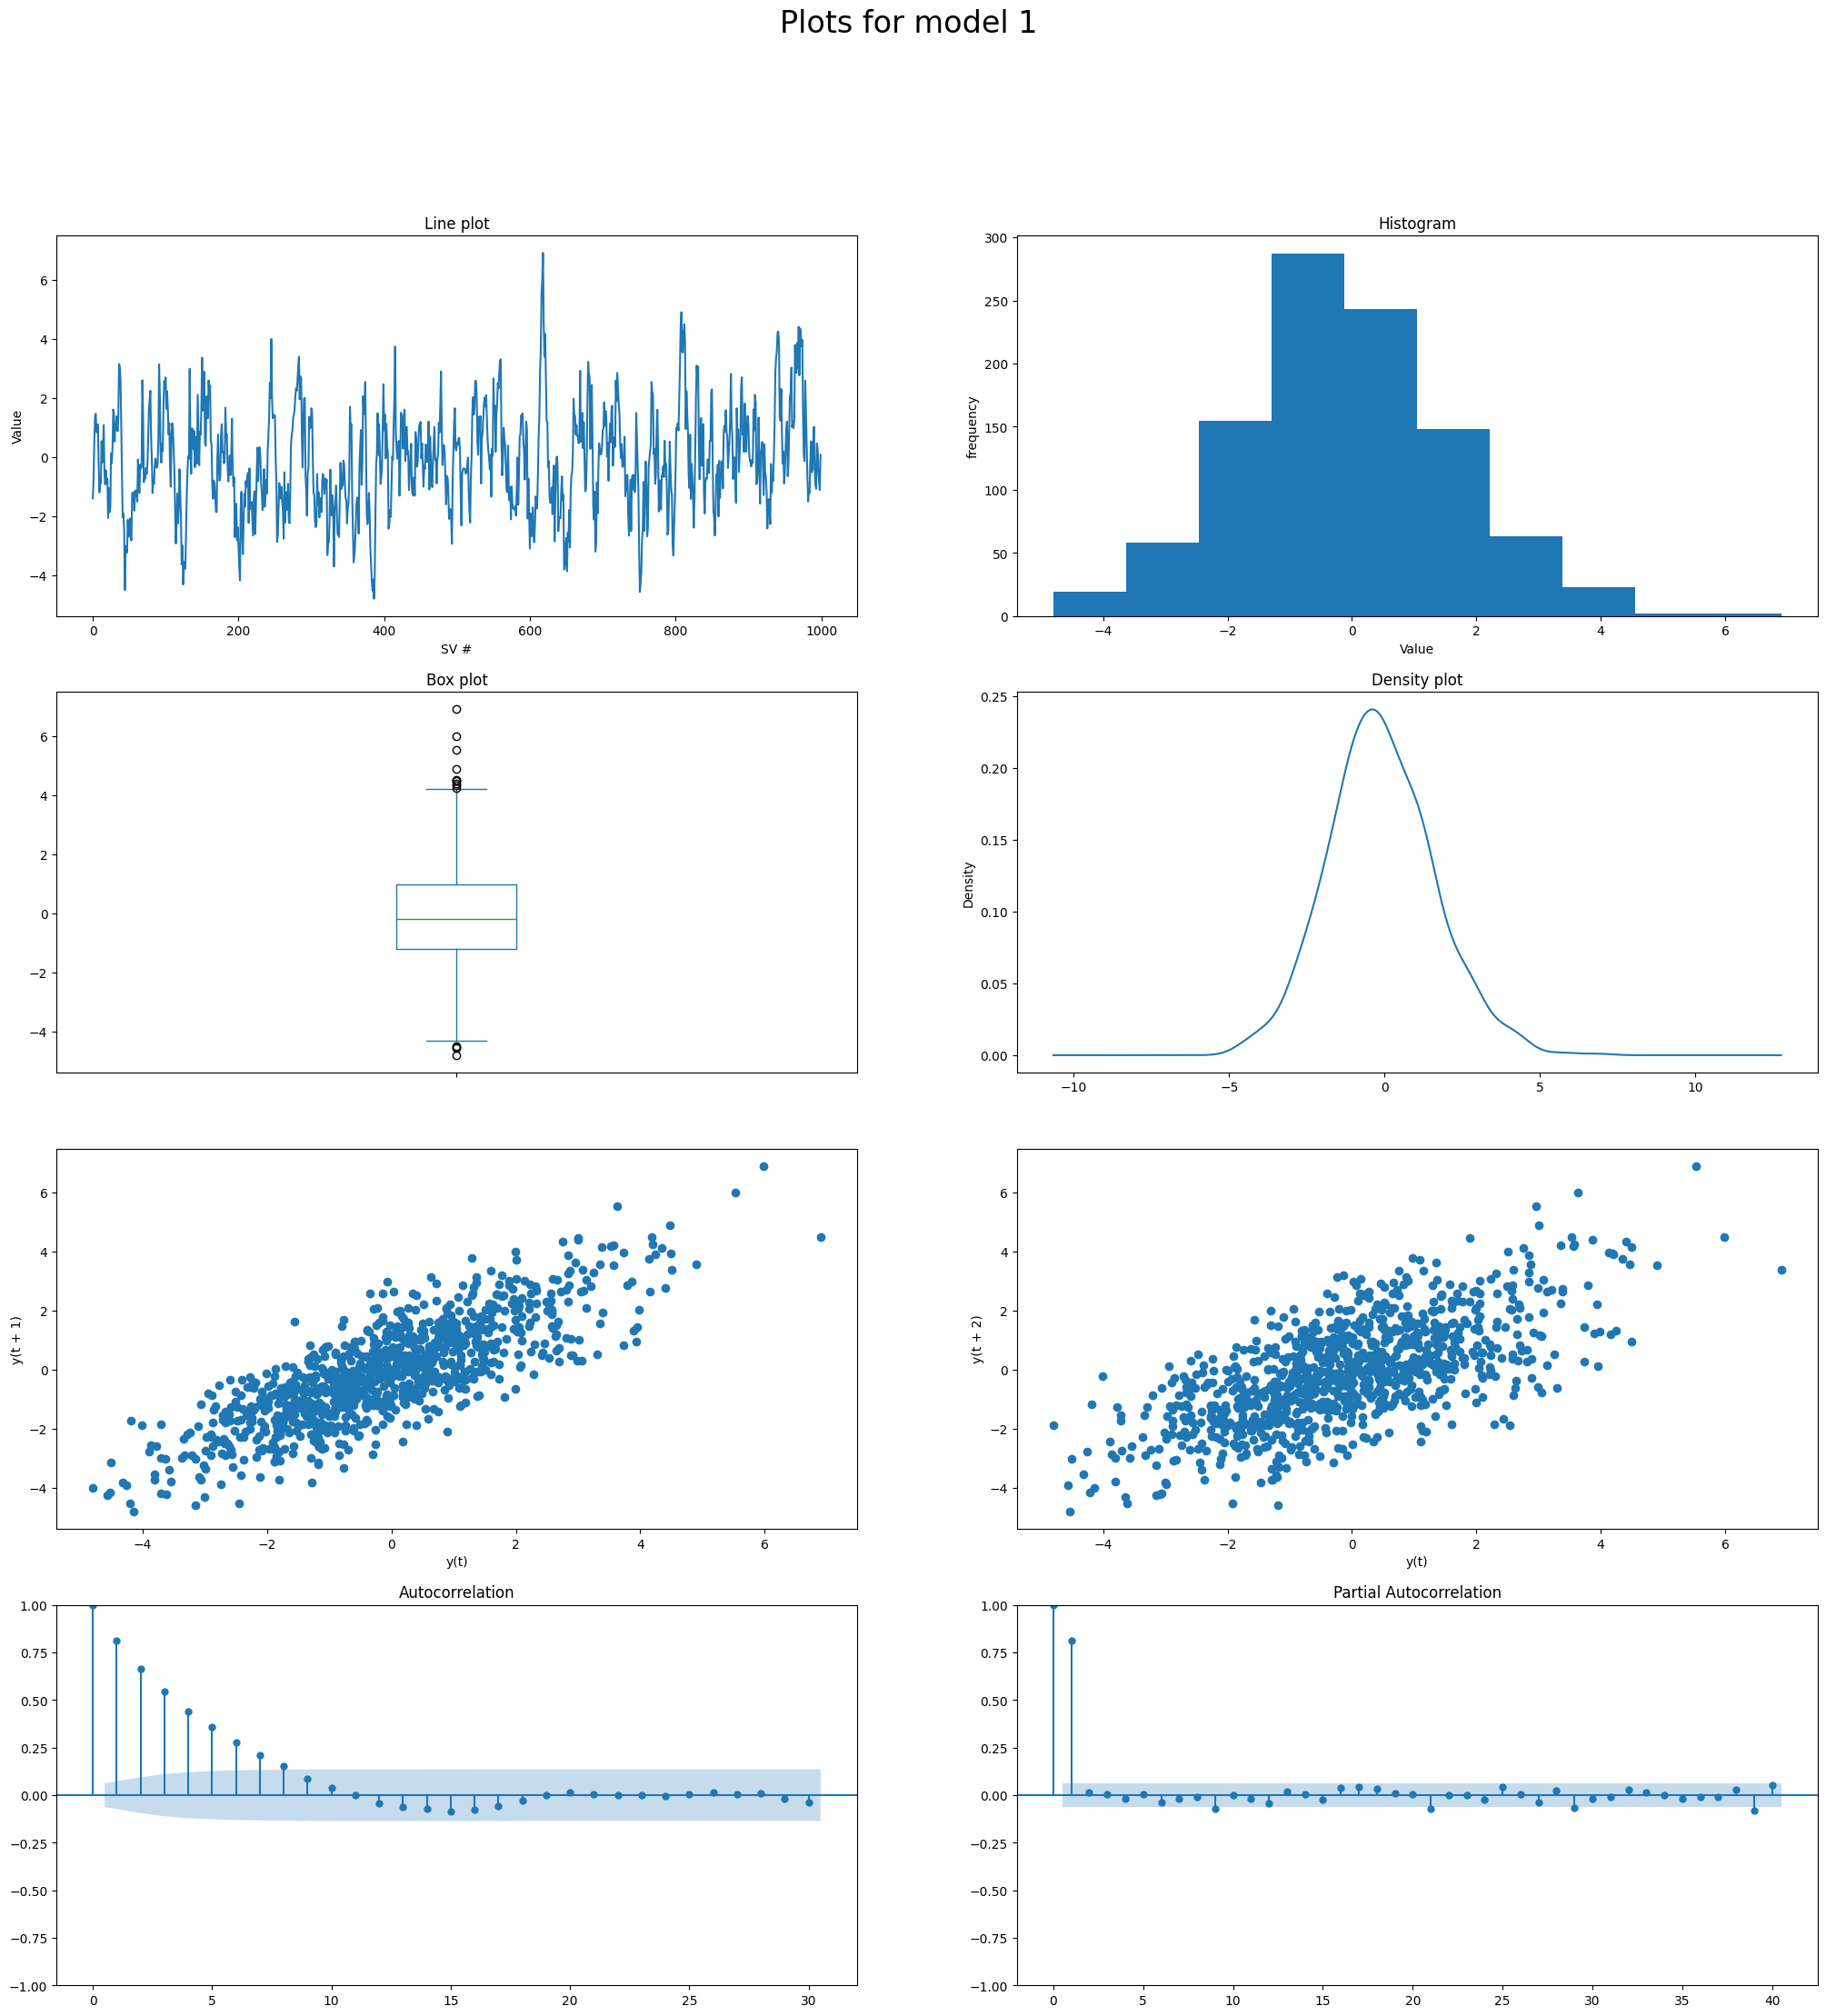

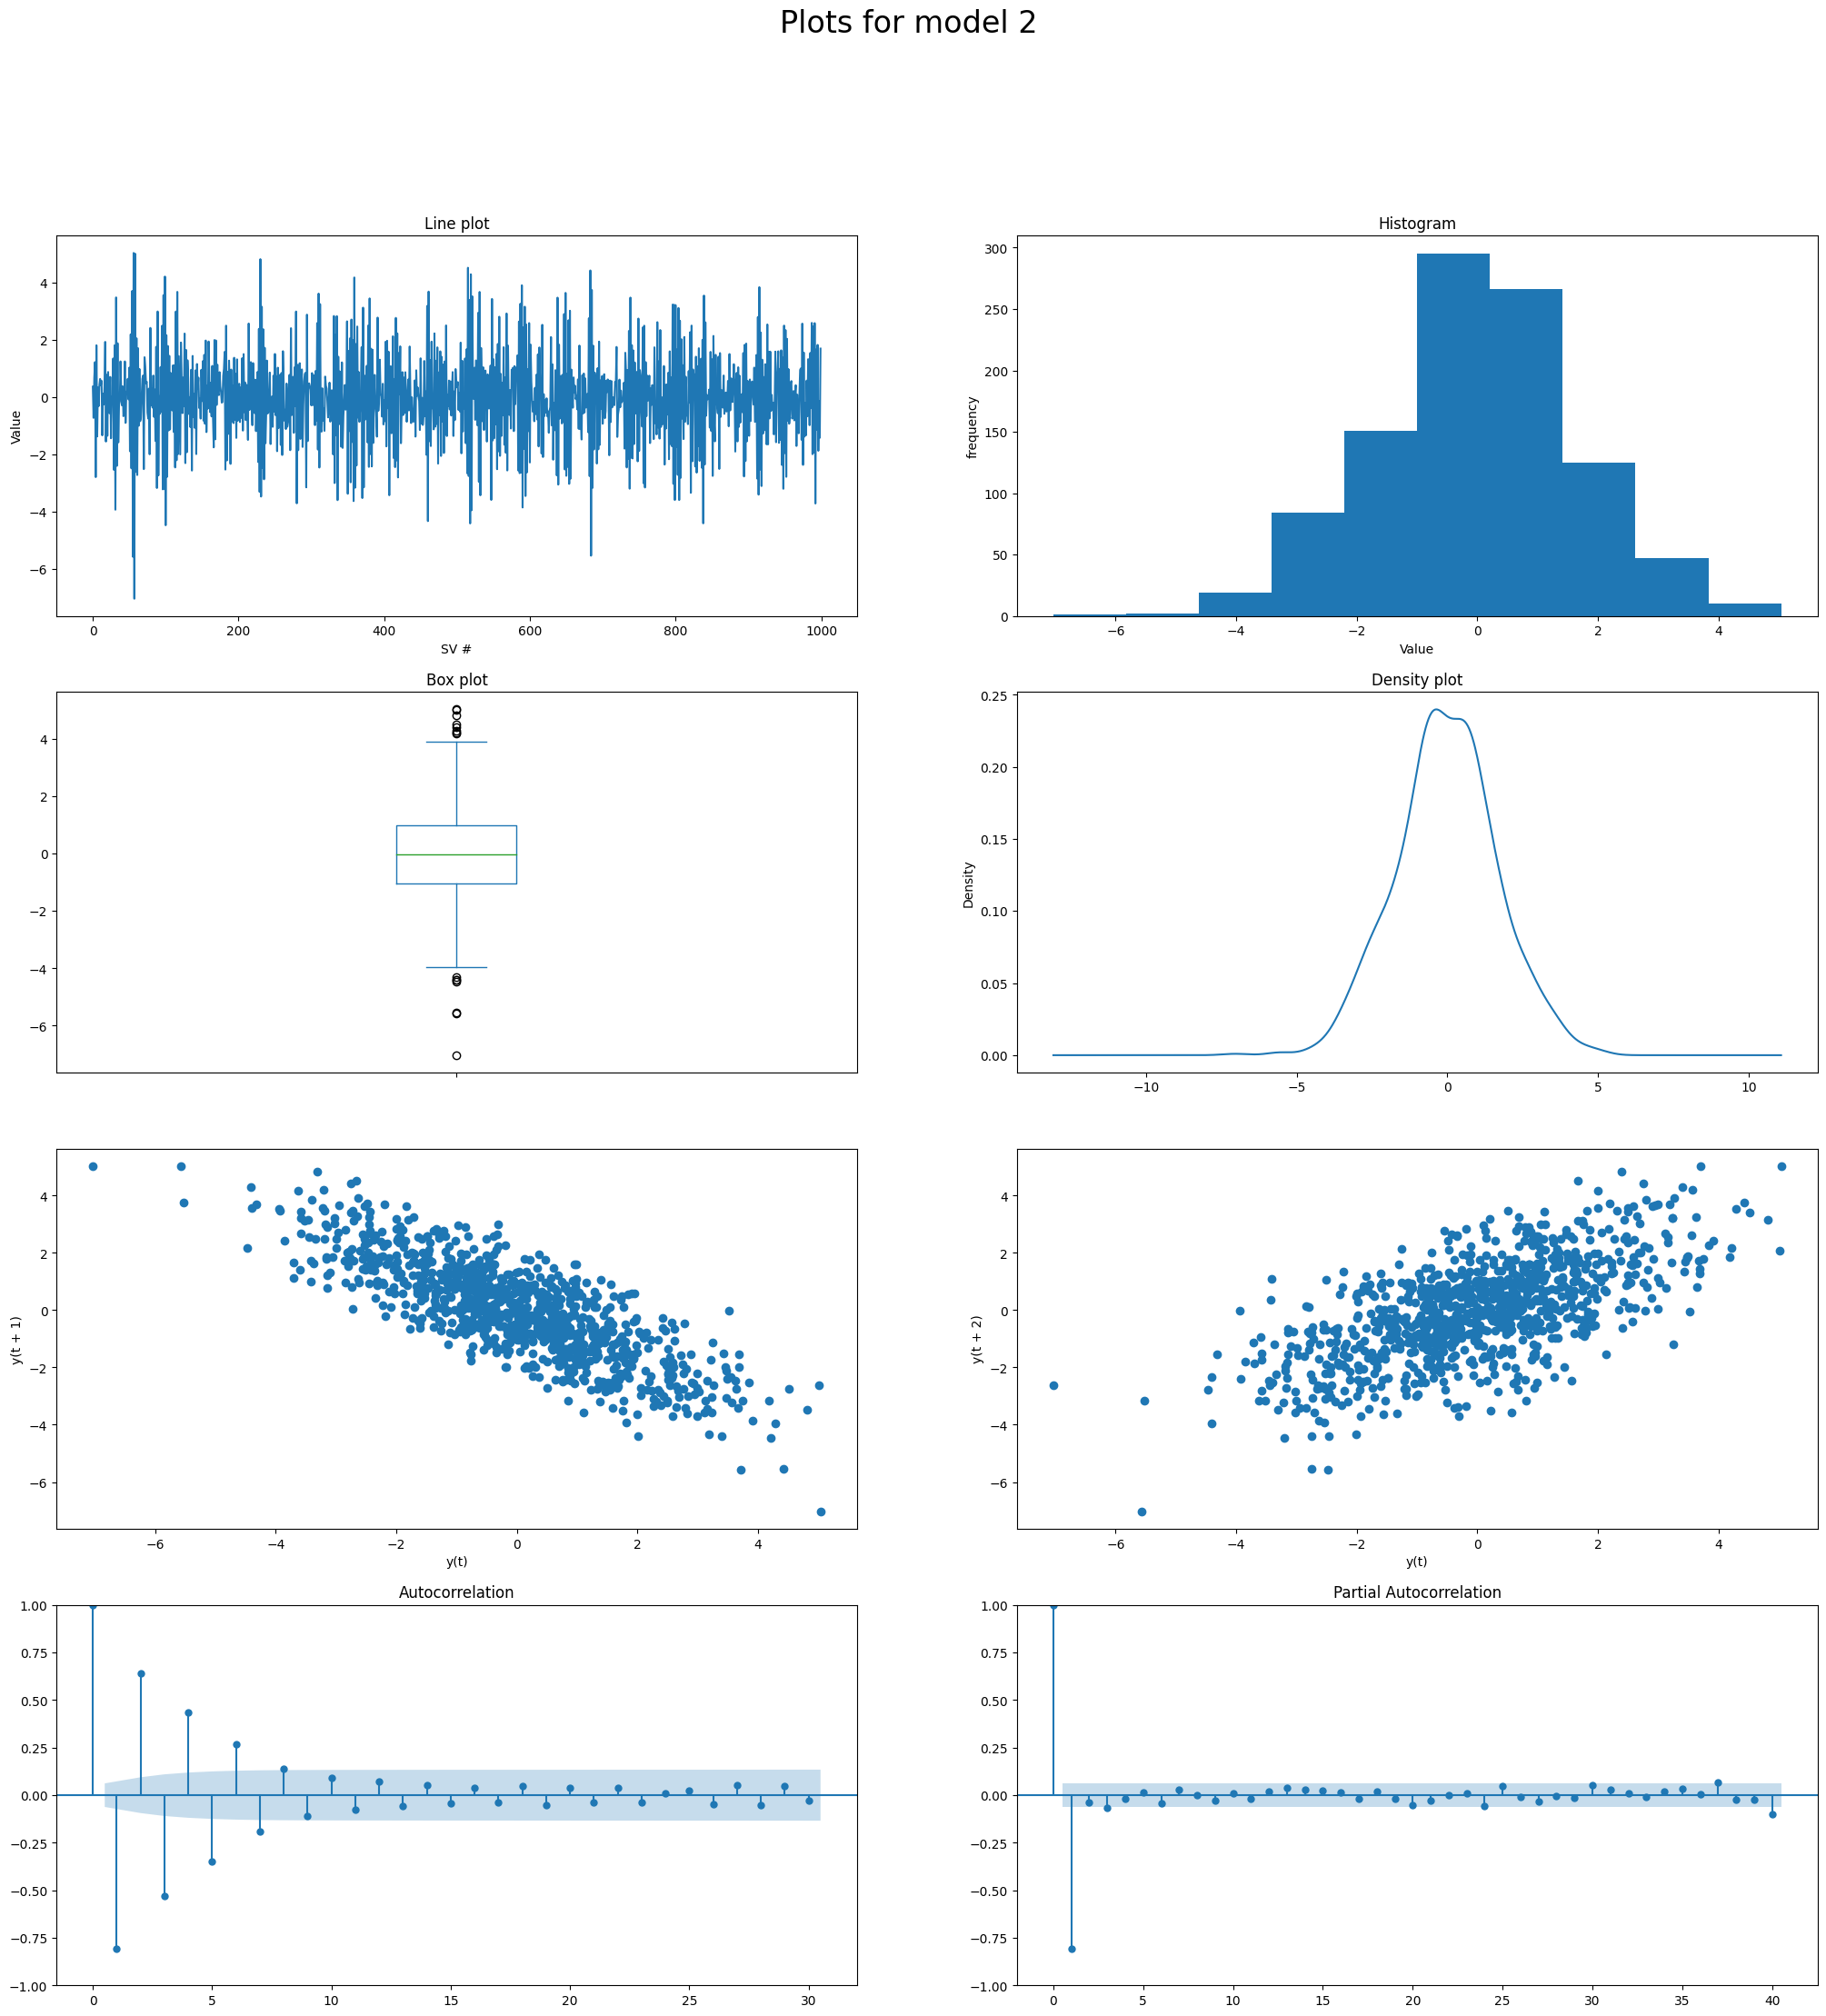

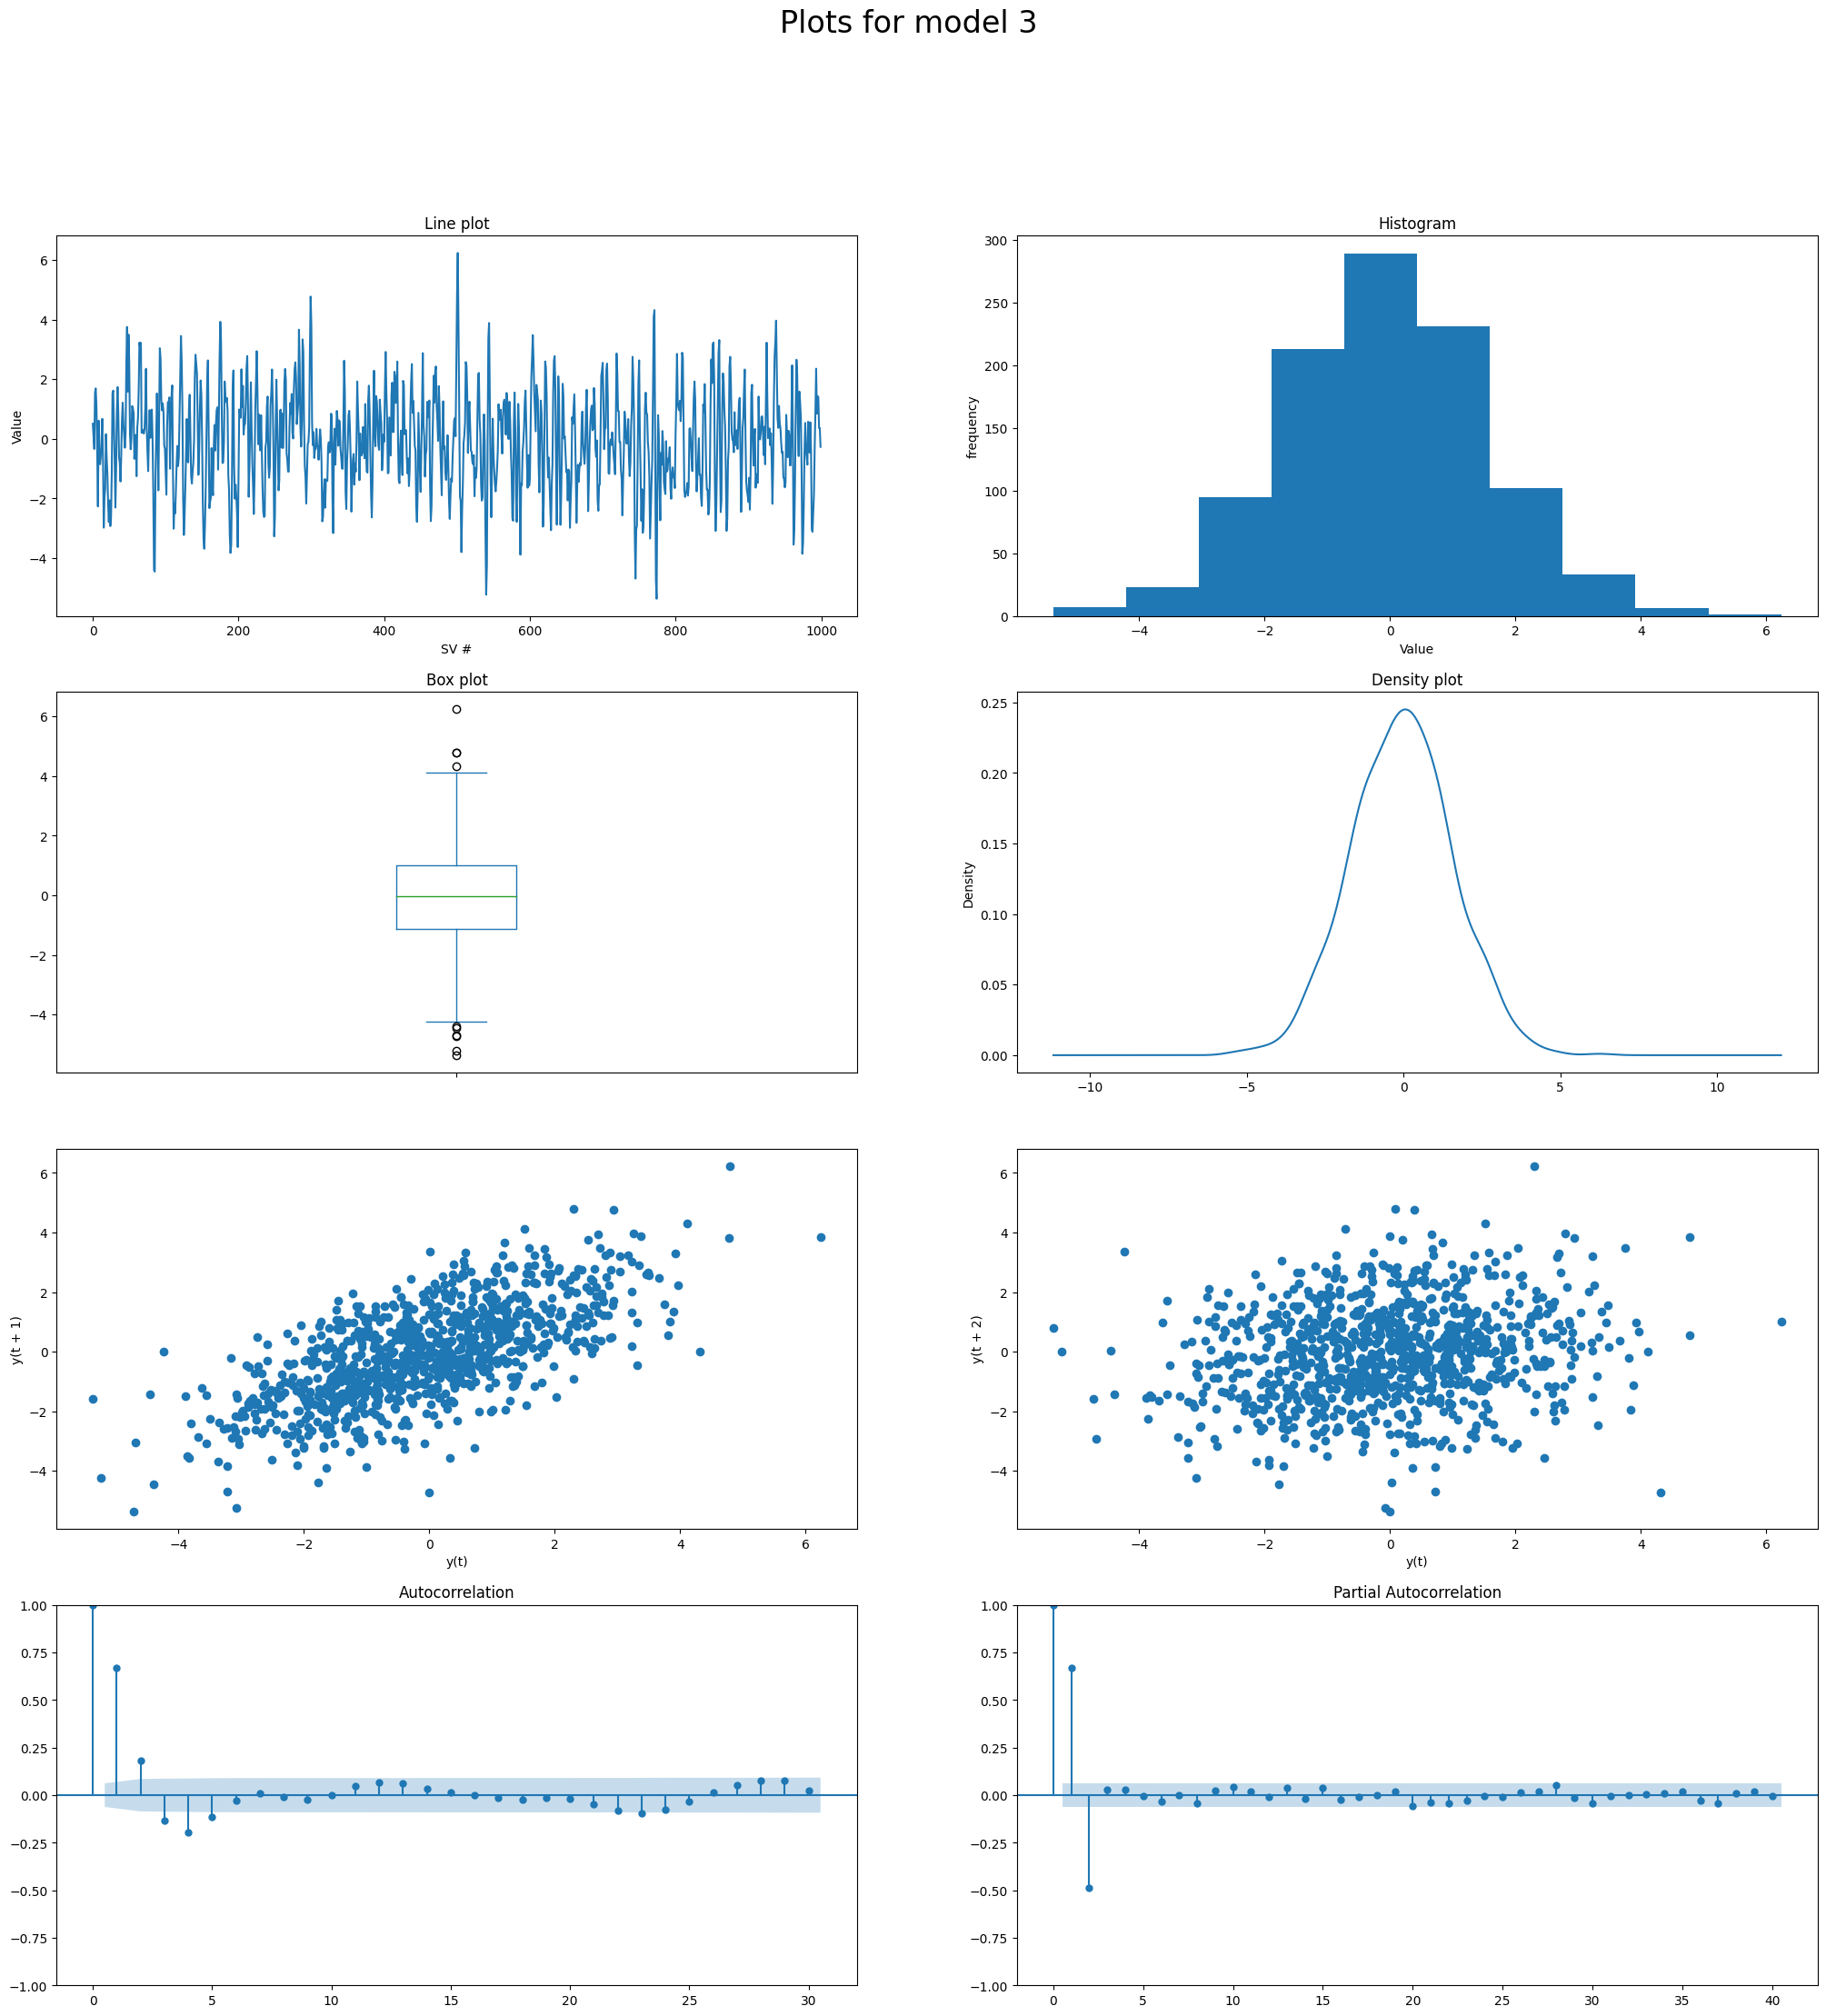

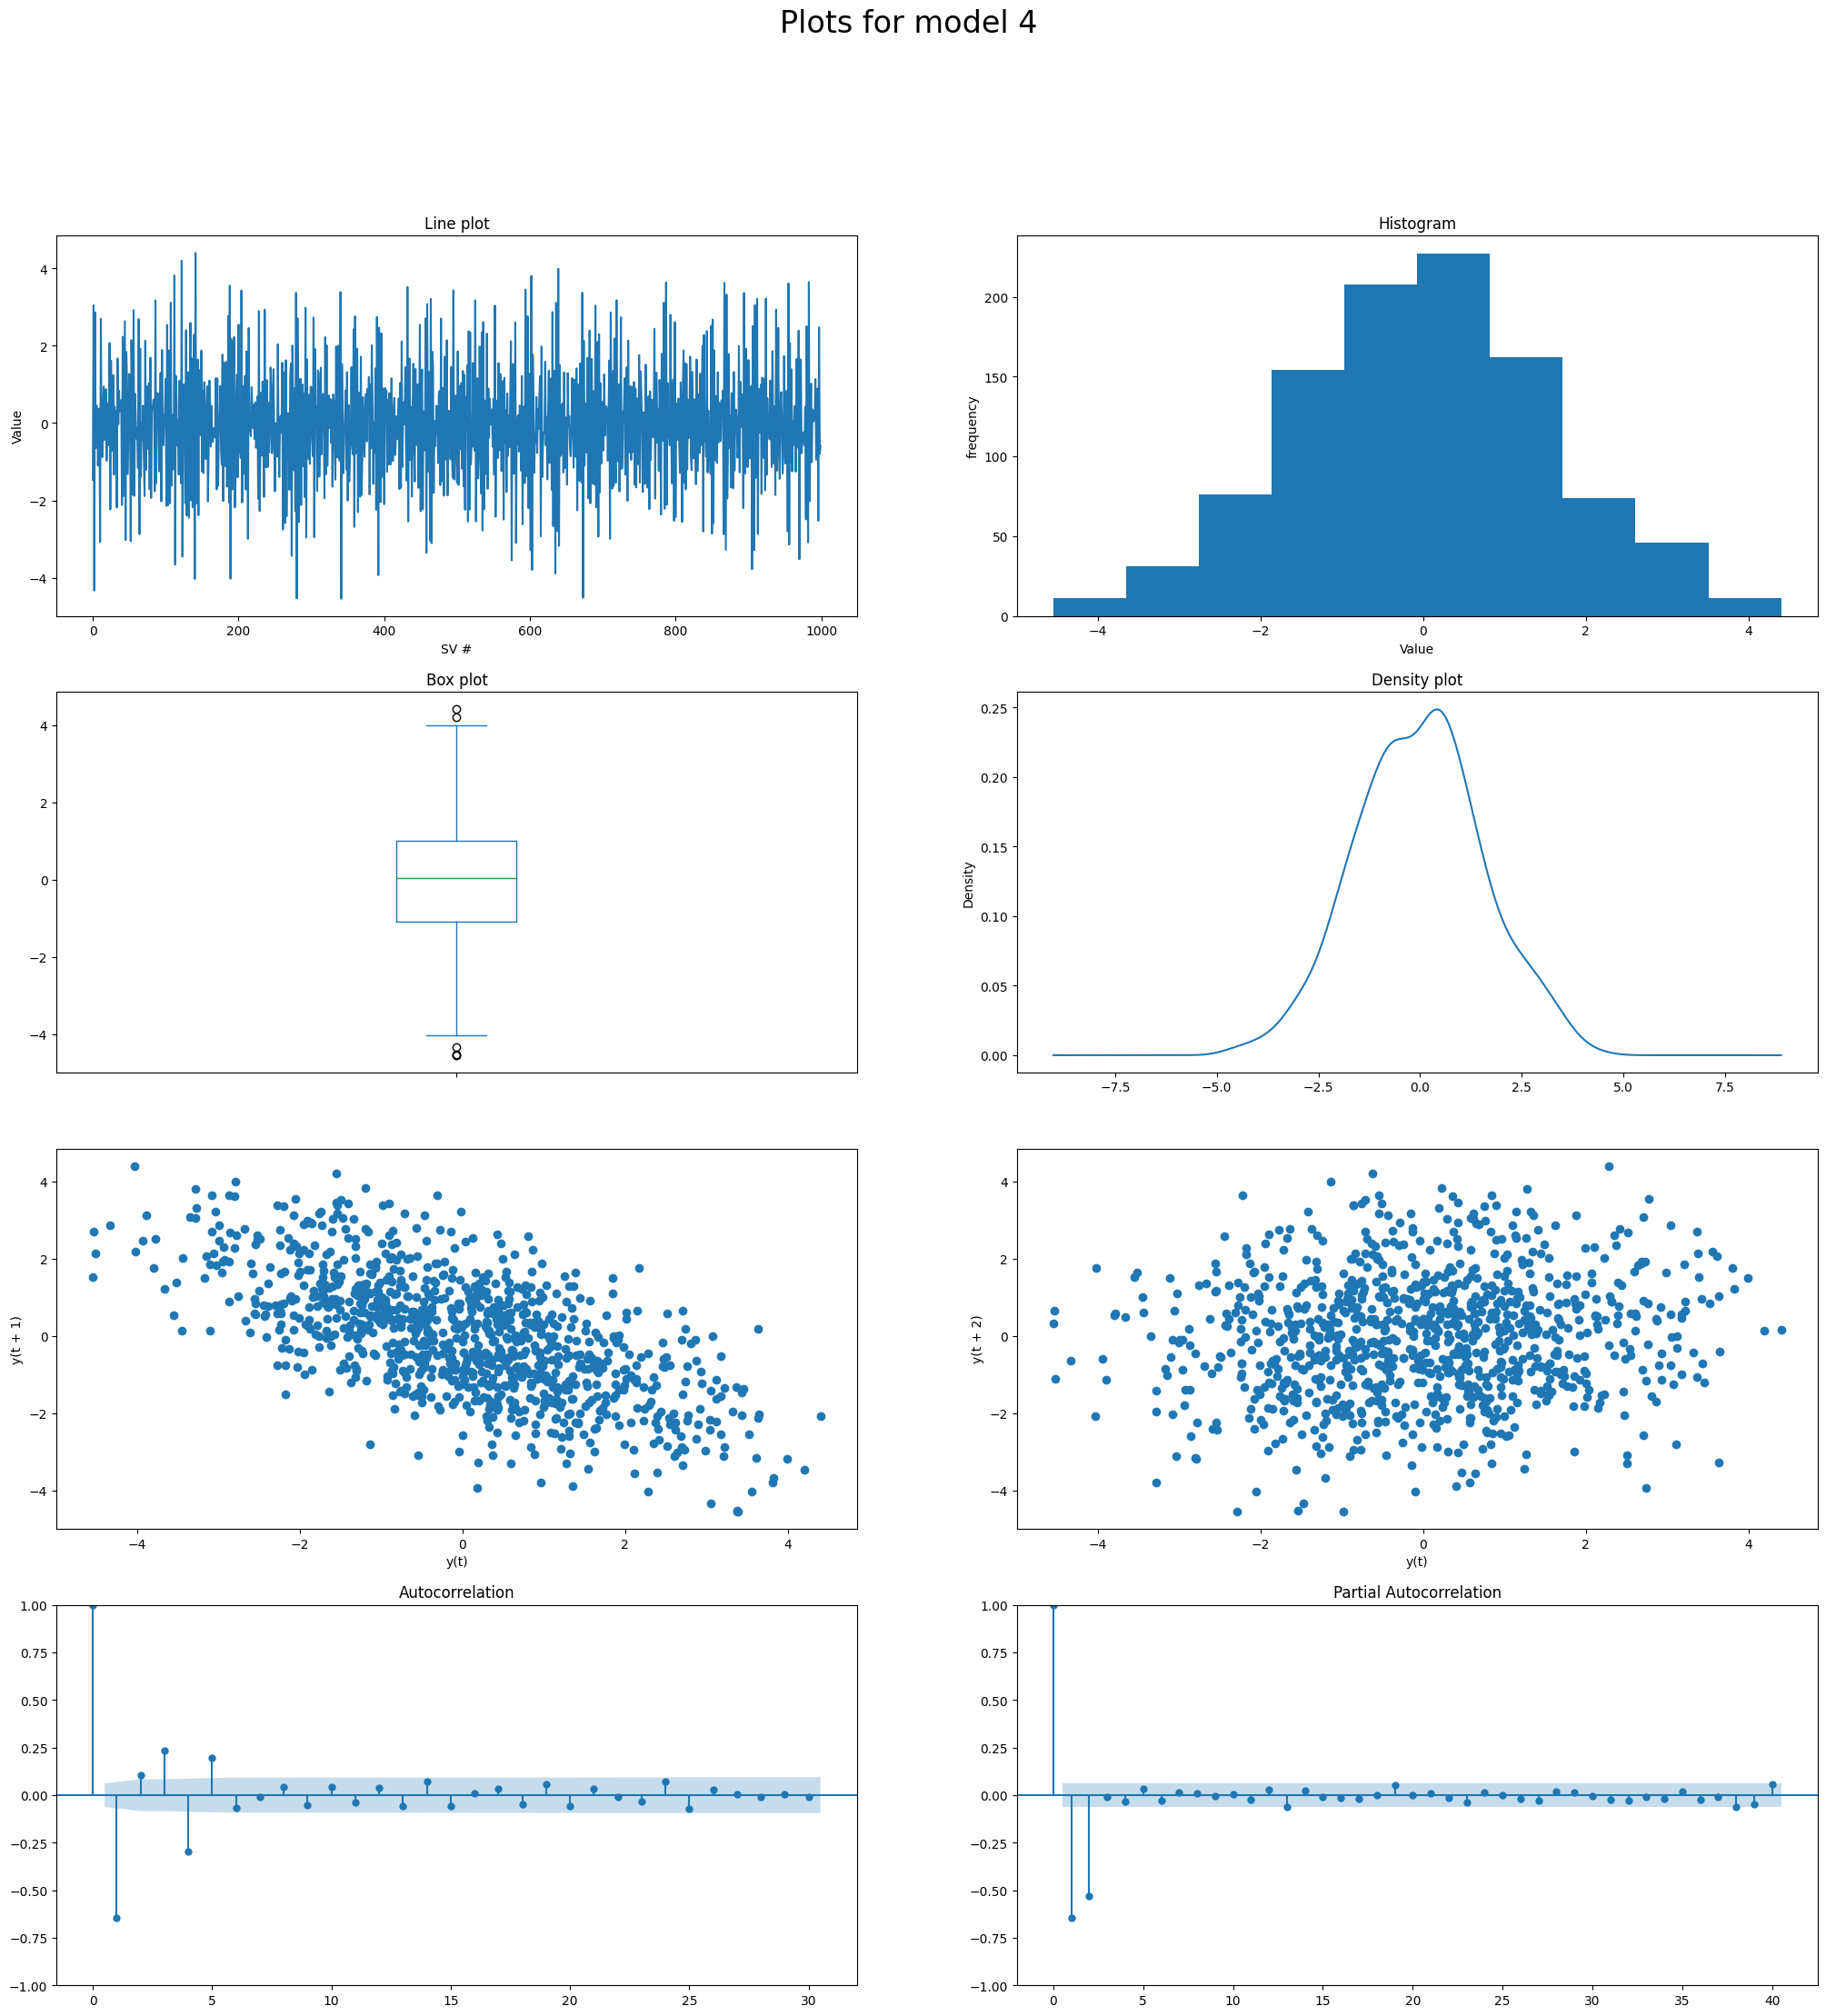

In [44]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8], nsample=1000)
s2, p2 = gen_arma(lagcoeffs_ar=[-0.8], nsample=1000)
s3, p3 = gen_arma(lagcoeffs_ar=[1, -0.5], nsample=1000)
s4, p4 = gen_arma(lagcoeffs_ar=[-1, -0.5], nsample=1000)

plot_all(Series(s1), lags=40, title="Plots for model 1");
plot_all(Series(s2), lags=40, title="Plots for model 2");
plot_all(Series(s3), lags=40, title="Plots for model 3");
plot_all(Series(s4), lags=40, title="Plots for model 4");

# Task 3: Invertibility, ACF, PACF of MA models

### Are all of them invertible, just by visual inspection?
It is uncertain whether invertibility can be determined through visual inspection. 

### Judge whether each time series is invertible or not, by its models’s auto-regressive coefficient values.
The following constraints are put on the coefficients to determine invertability of the MA(p) model, where $\theta_t$ is the coefficient:

- For q = 1: <u>−1 < $\theta_1$ < 1</u>
- For q = 2: <u>−1 < $\theta_2$ < 1</u> AND <u>$\theta_2$ + $\theta_1$ < 1</u> AND <u>$\theta_1$ − $\theta_2$ < 1</u>

- 1) MA(1) = $\epsilon_t - 2 \epsilon_{t-1} \rightarrow -1 < \theta_1 = 2 < 1$, which **not fulfill** the invertibility condition for $p = 1$.
- 2) MA(1) = $\epsilon_t - 0.5 \epsilon_{t-1} \rightarrow -1 > \theta_1 = 0.5$, which does **fulfill** the invertibility condition for $p = 1$.
- 3) MA(2) = $\epsilon_t - \frac{4}{5} \epsilon_{t-1} + \frac{16}{25} \epsilon_{t-2} \rightarrow -1 < \theta_2 = 16/25 < 1$, $\theta_2 + \theta_1 = -0.16 > -1$, and $\theta_1 - \theta_2 = 0.16 < 1$, which **fulfills** the invertibility condition for $p = 2$.
- 4) MA(2) = $\epsilon_t - \frac{5}{4} \epsilon_{t-1} + \frac{25}{16} \epsilon_{t-2} \rightarrow -1 < \theta_2 = 25/16$, but $> 1$ which does **not fulfill** the invertibility because of the first criterion for p = 2.

### Call the following statsmodel function to judge if each MA process is invertible
The function calls show us that processes 1 and 4 are **not** invertible, whereas processses 2 and 3 **are** invertible.

### Draw histogram, density plot, and box plot for each time series with 1000 data points. Are there any outliers? Why?
Outliers occur in most cases. They exist because the error distribution can sometimes generate values outside the standard confidence intervals simply and then they become outliers in the box plot.

### Draw lag-1 and lag-2 plots for each time series. Do you observe any auto-correlation from the lag plots?
There is no discernible auto-correlation in the lag plots.

## Questions

### Are all the MA models invertible? If not, which ones are invertible and which ones are not invertible?
The second (2nd) and third (3rd) are invertble, the remaining are not.

### What characteristics can you observe from the ACF graphs of the MA(q) models?
In regards to invertibility, since two different MA(q) models can generate the same ACF graph, not conclusion can be drawn.

### What characteristics can you observe from the PACF graphs of the MA(q) models?
In regards to invertibility, since two different MA(q) models can generate the same PACF graph, not conclusion can be drawn.


### To have an MA(q) model be invertible, is there any requirement on the auto-regressive coefficients? List the constraints for MA(1) and MA(2) models.
The following constraints are required on the MA(1) and MA(2) models for invertibility

- For q = 1: <u>−1 < $\theta_1$ < 1</u>
- For q = 2: <u>−1 < $\theta_2$ < 1</u> AND <u>$\theta_2$ + $\theta_1$ < 1</u> AND <u>$\theta_2$ − $\theta_1$ < 1</u>

Is process 1 invertible? False
Is process 2 invertible? True
Is process 3 invertible? True
Is process 4 invertible? False


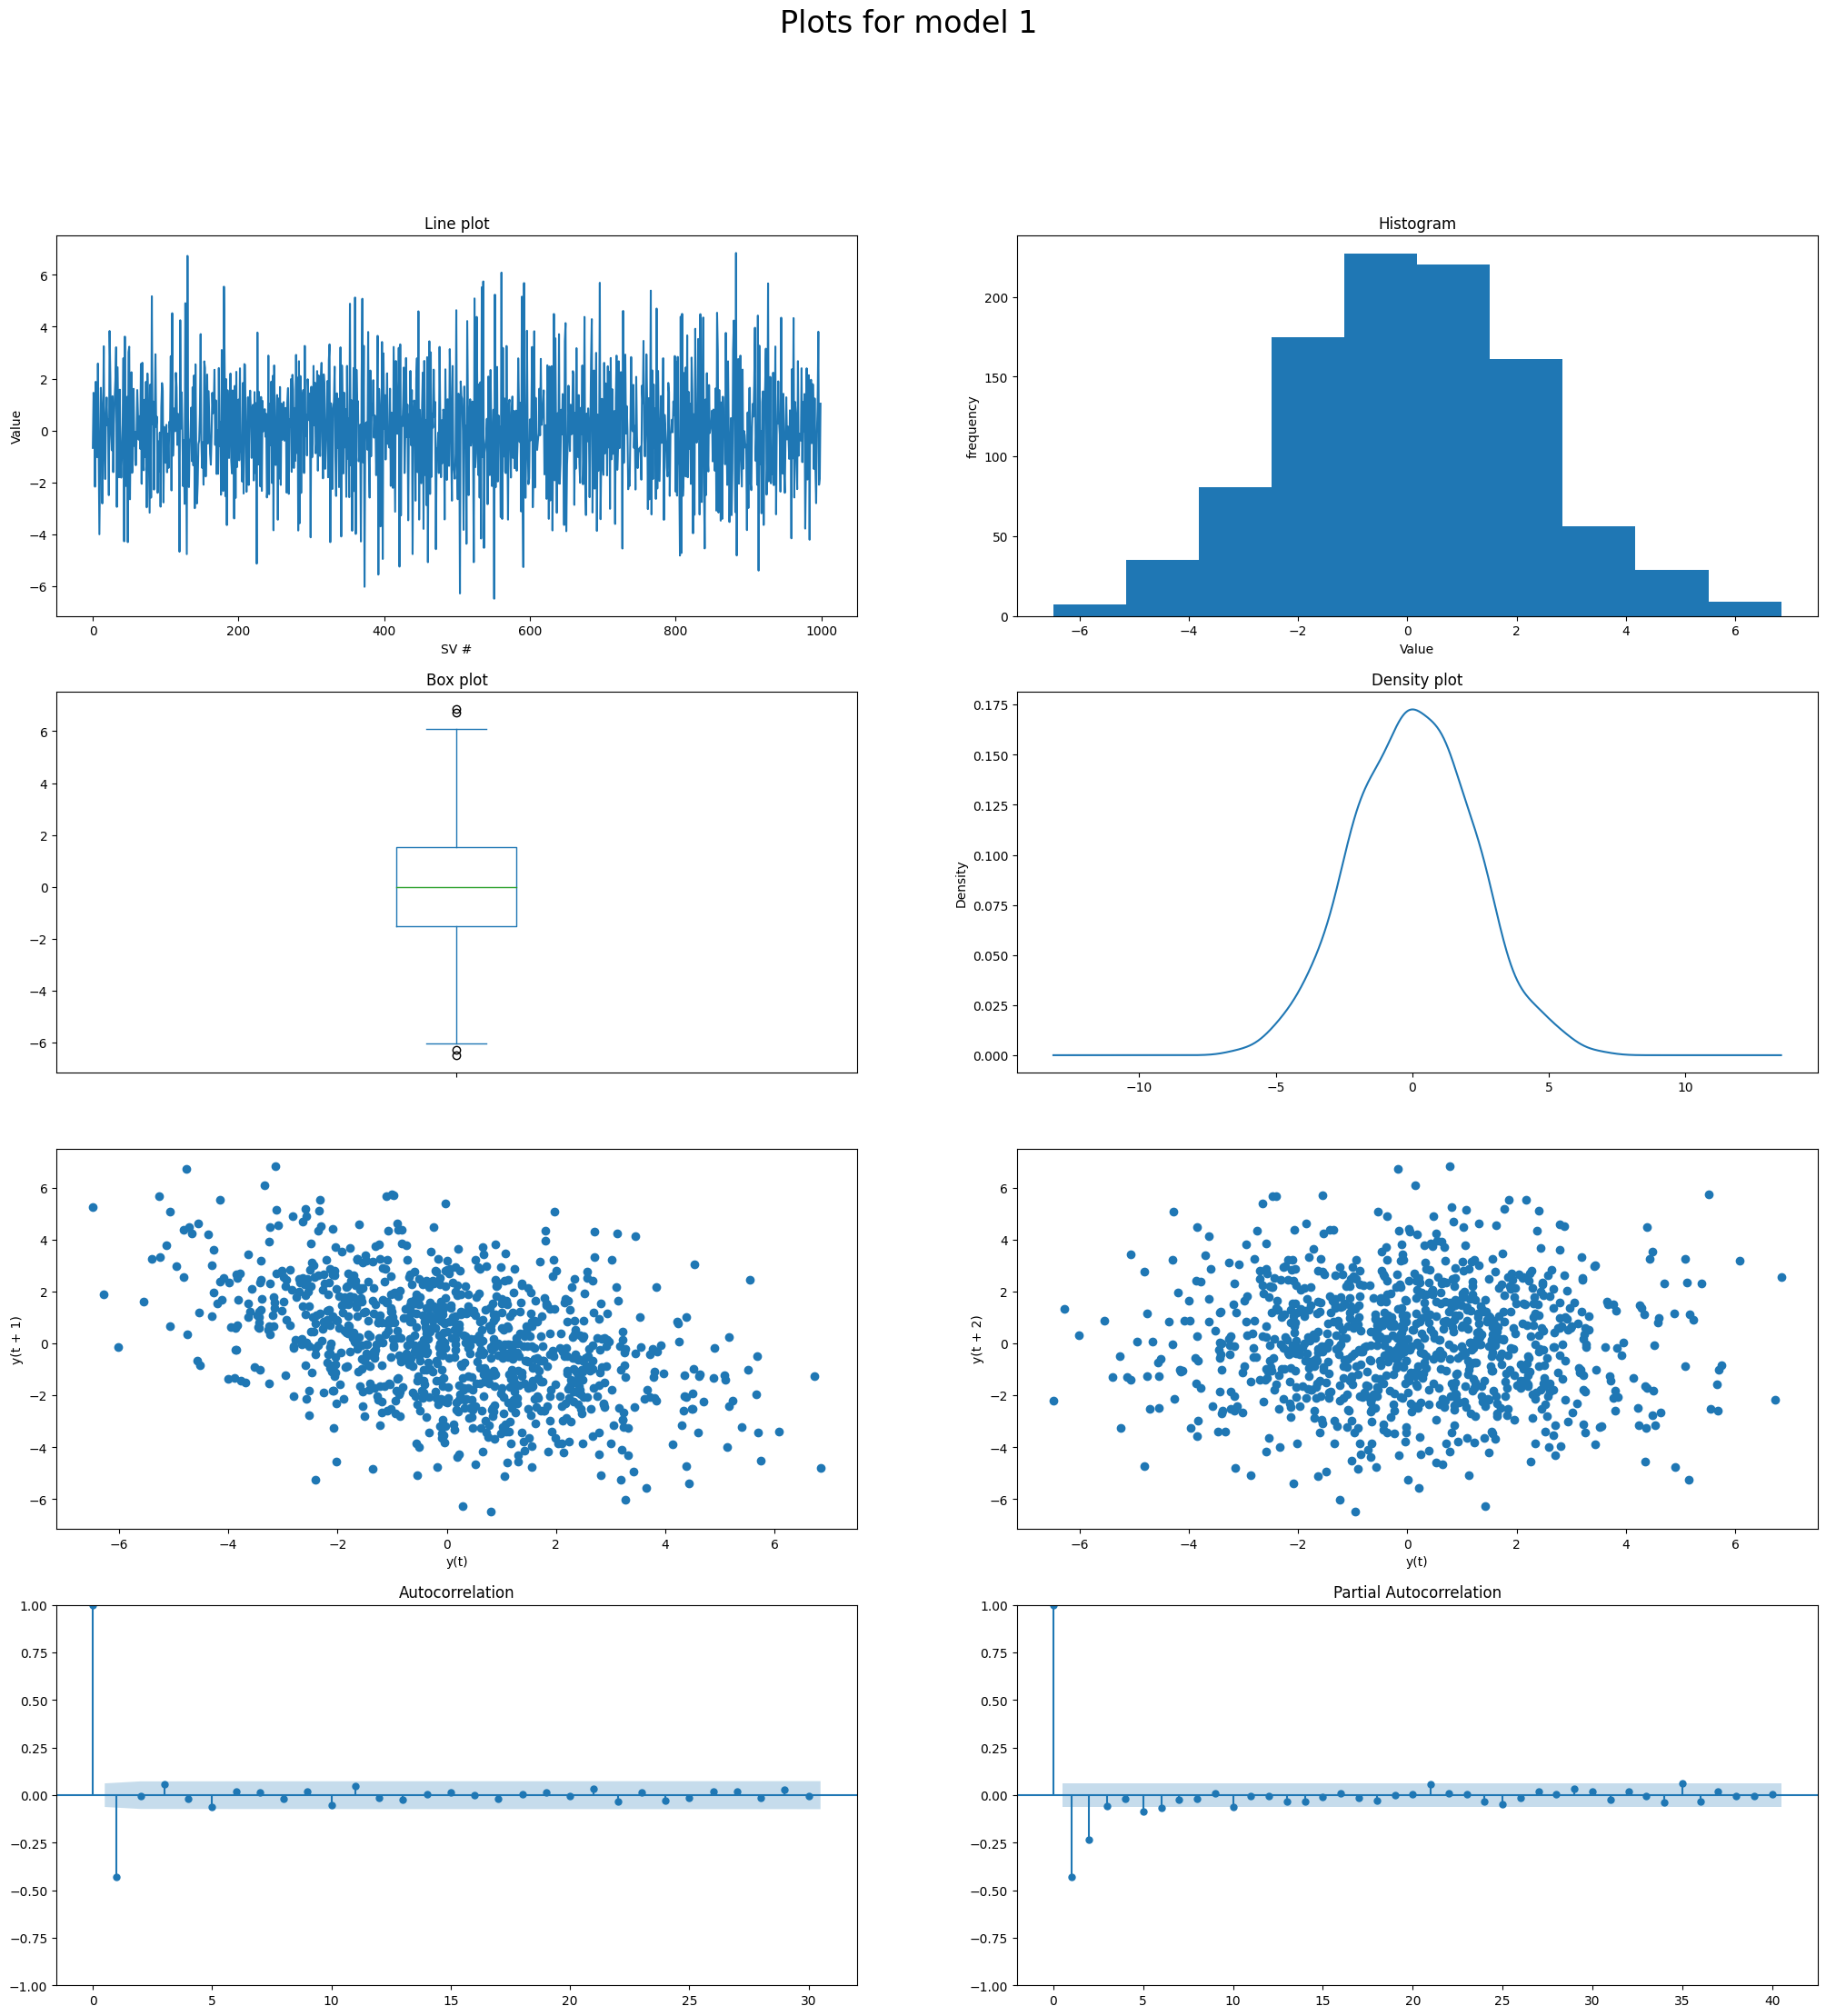

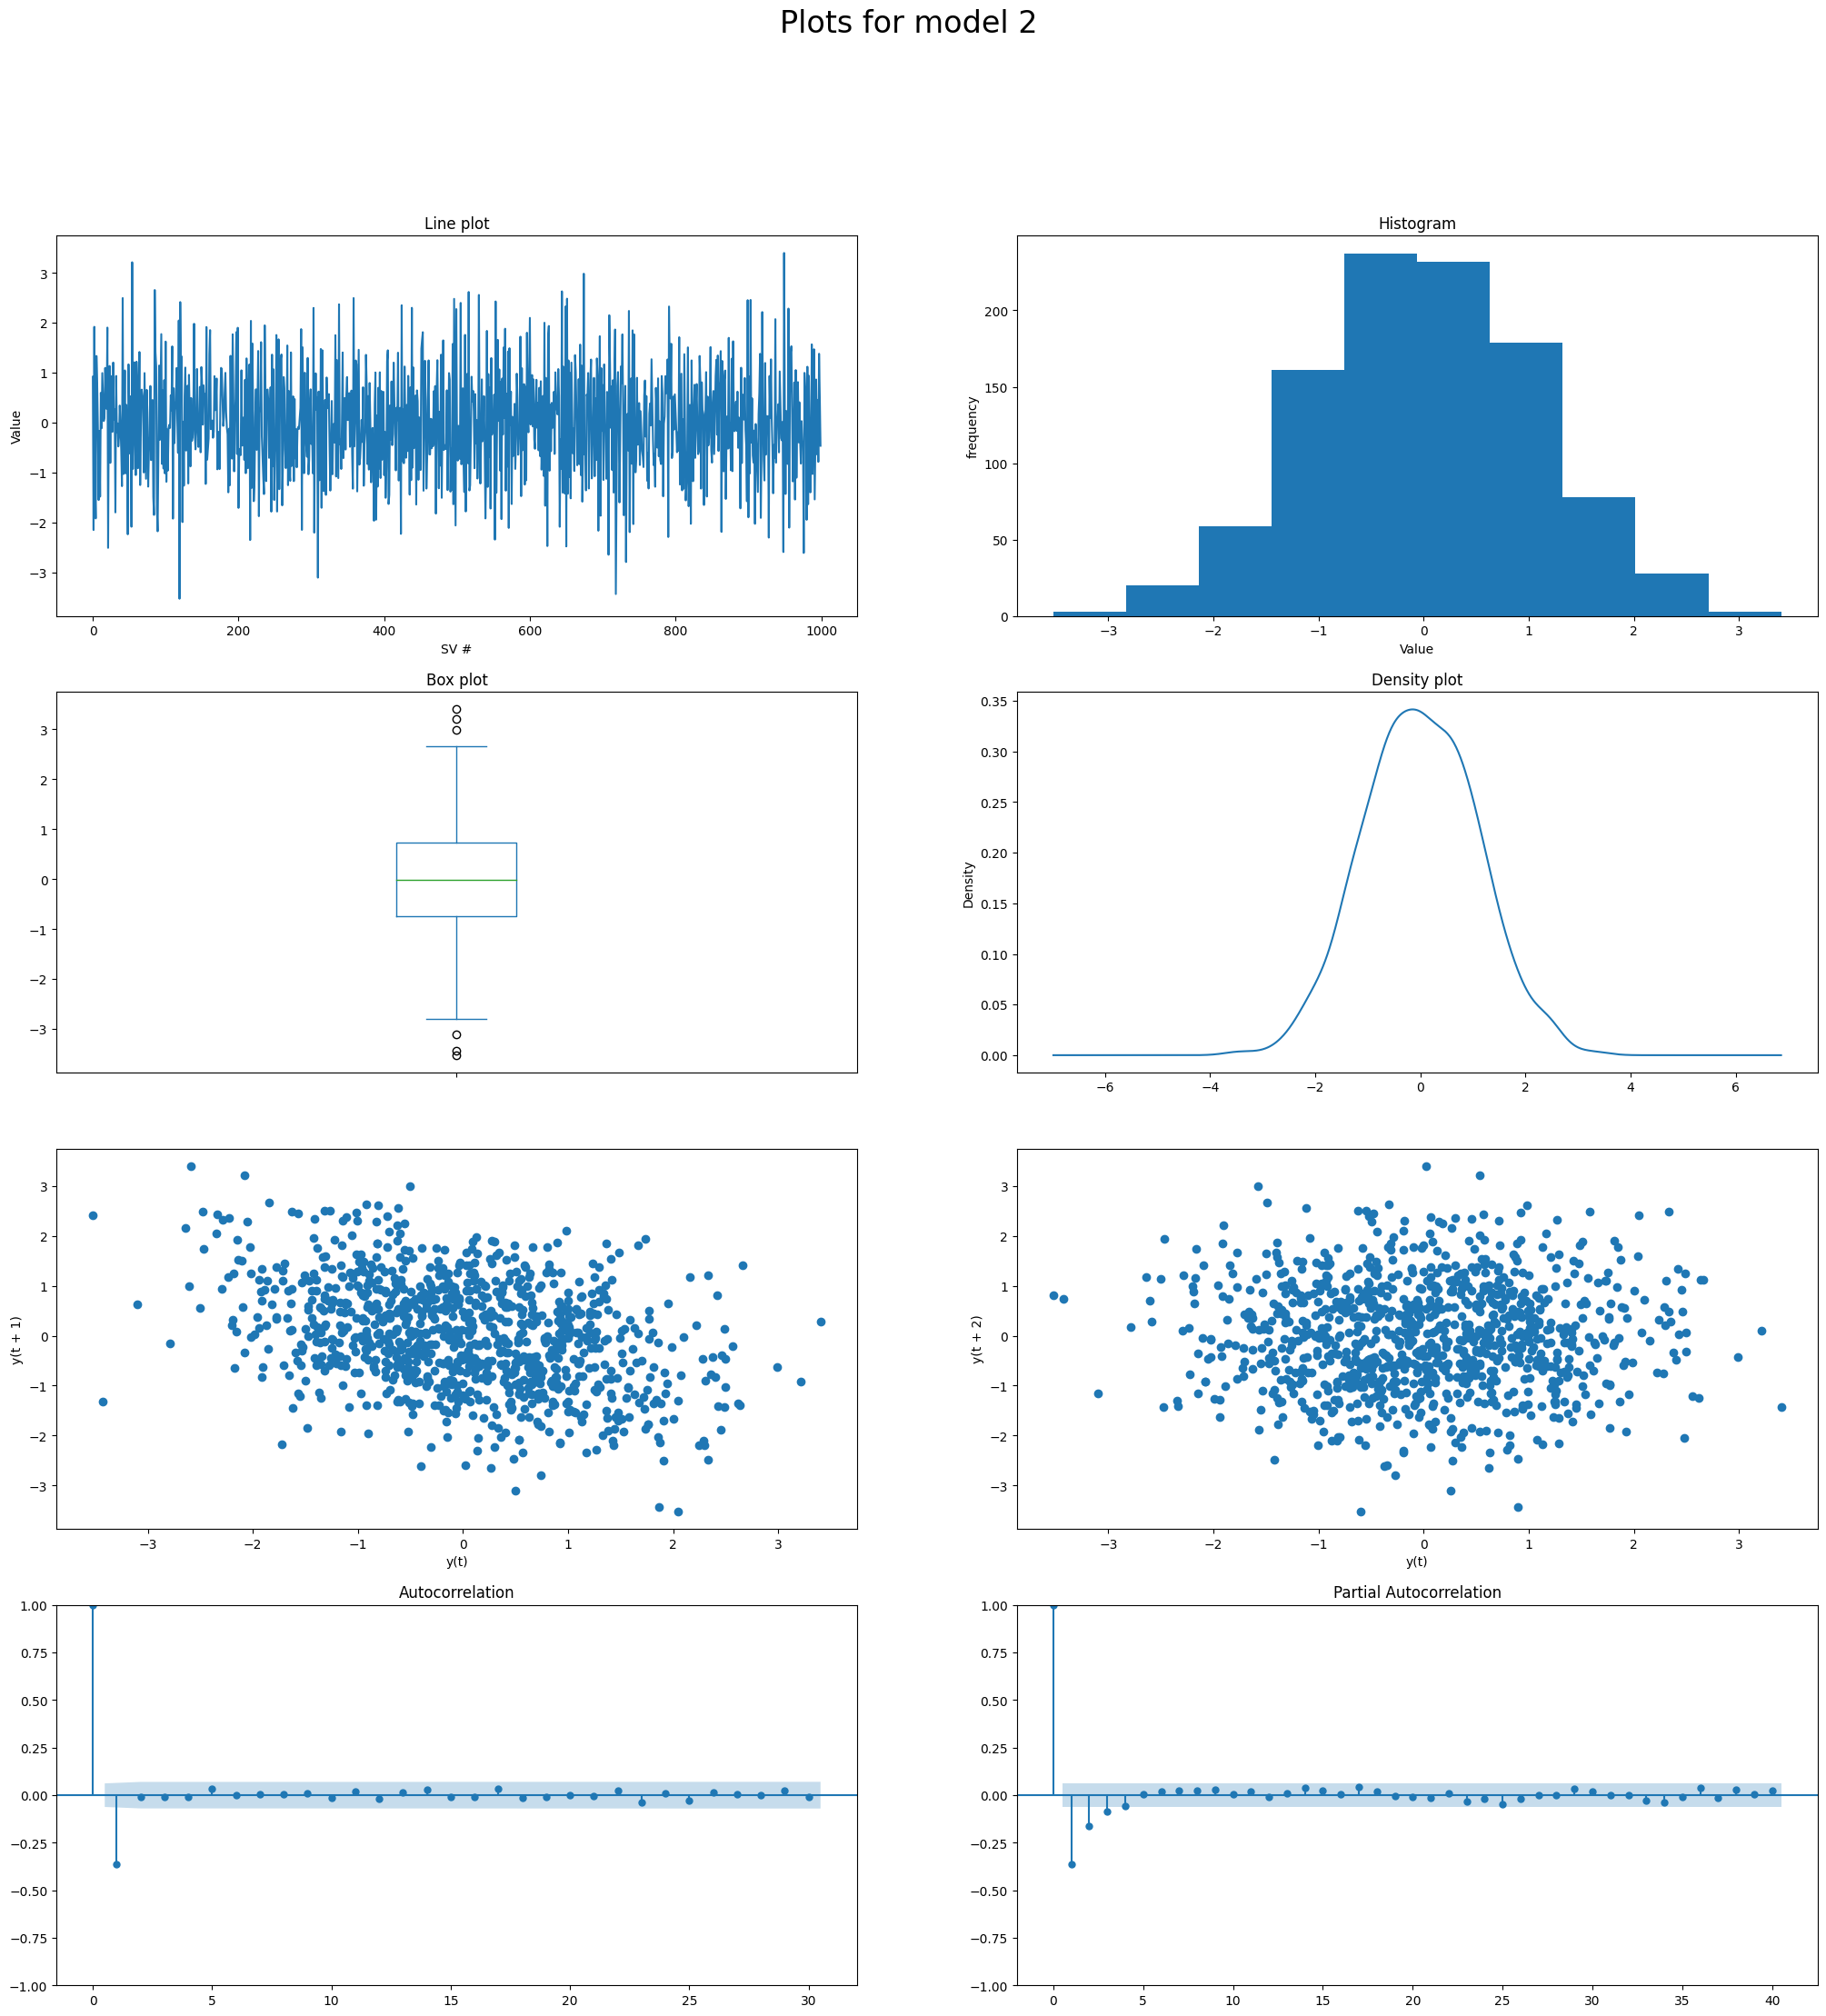

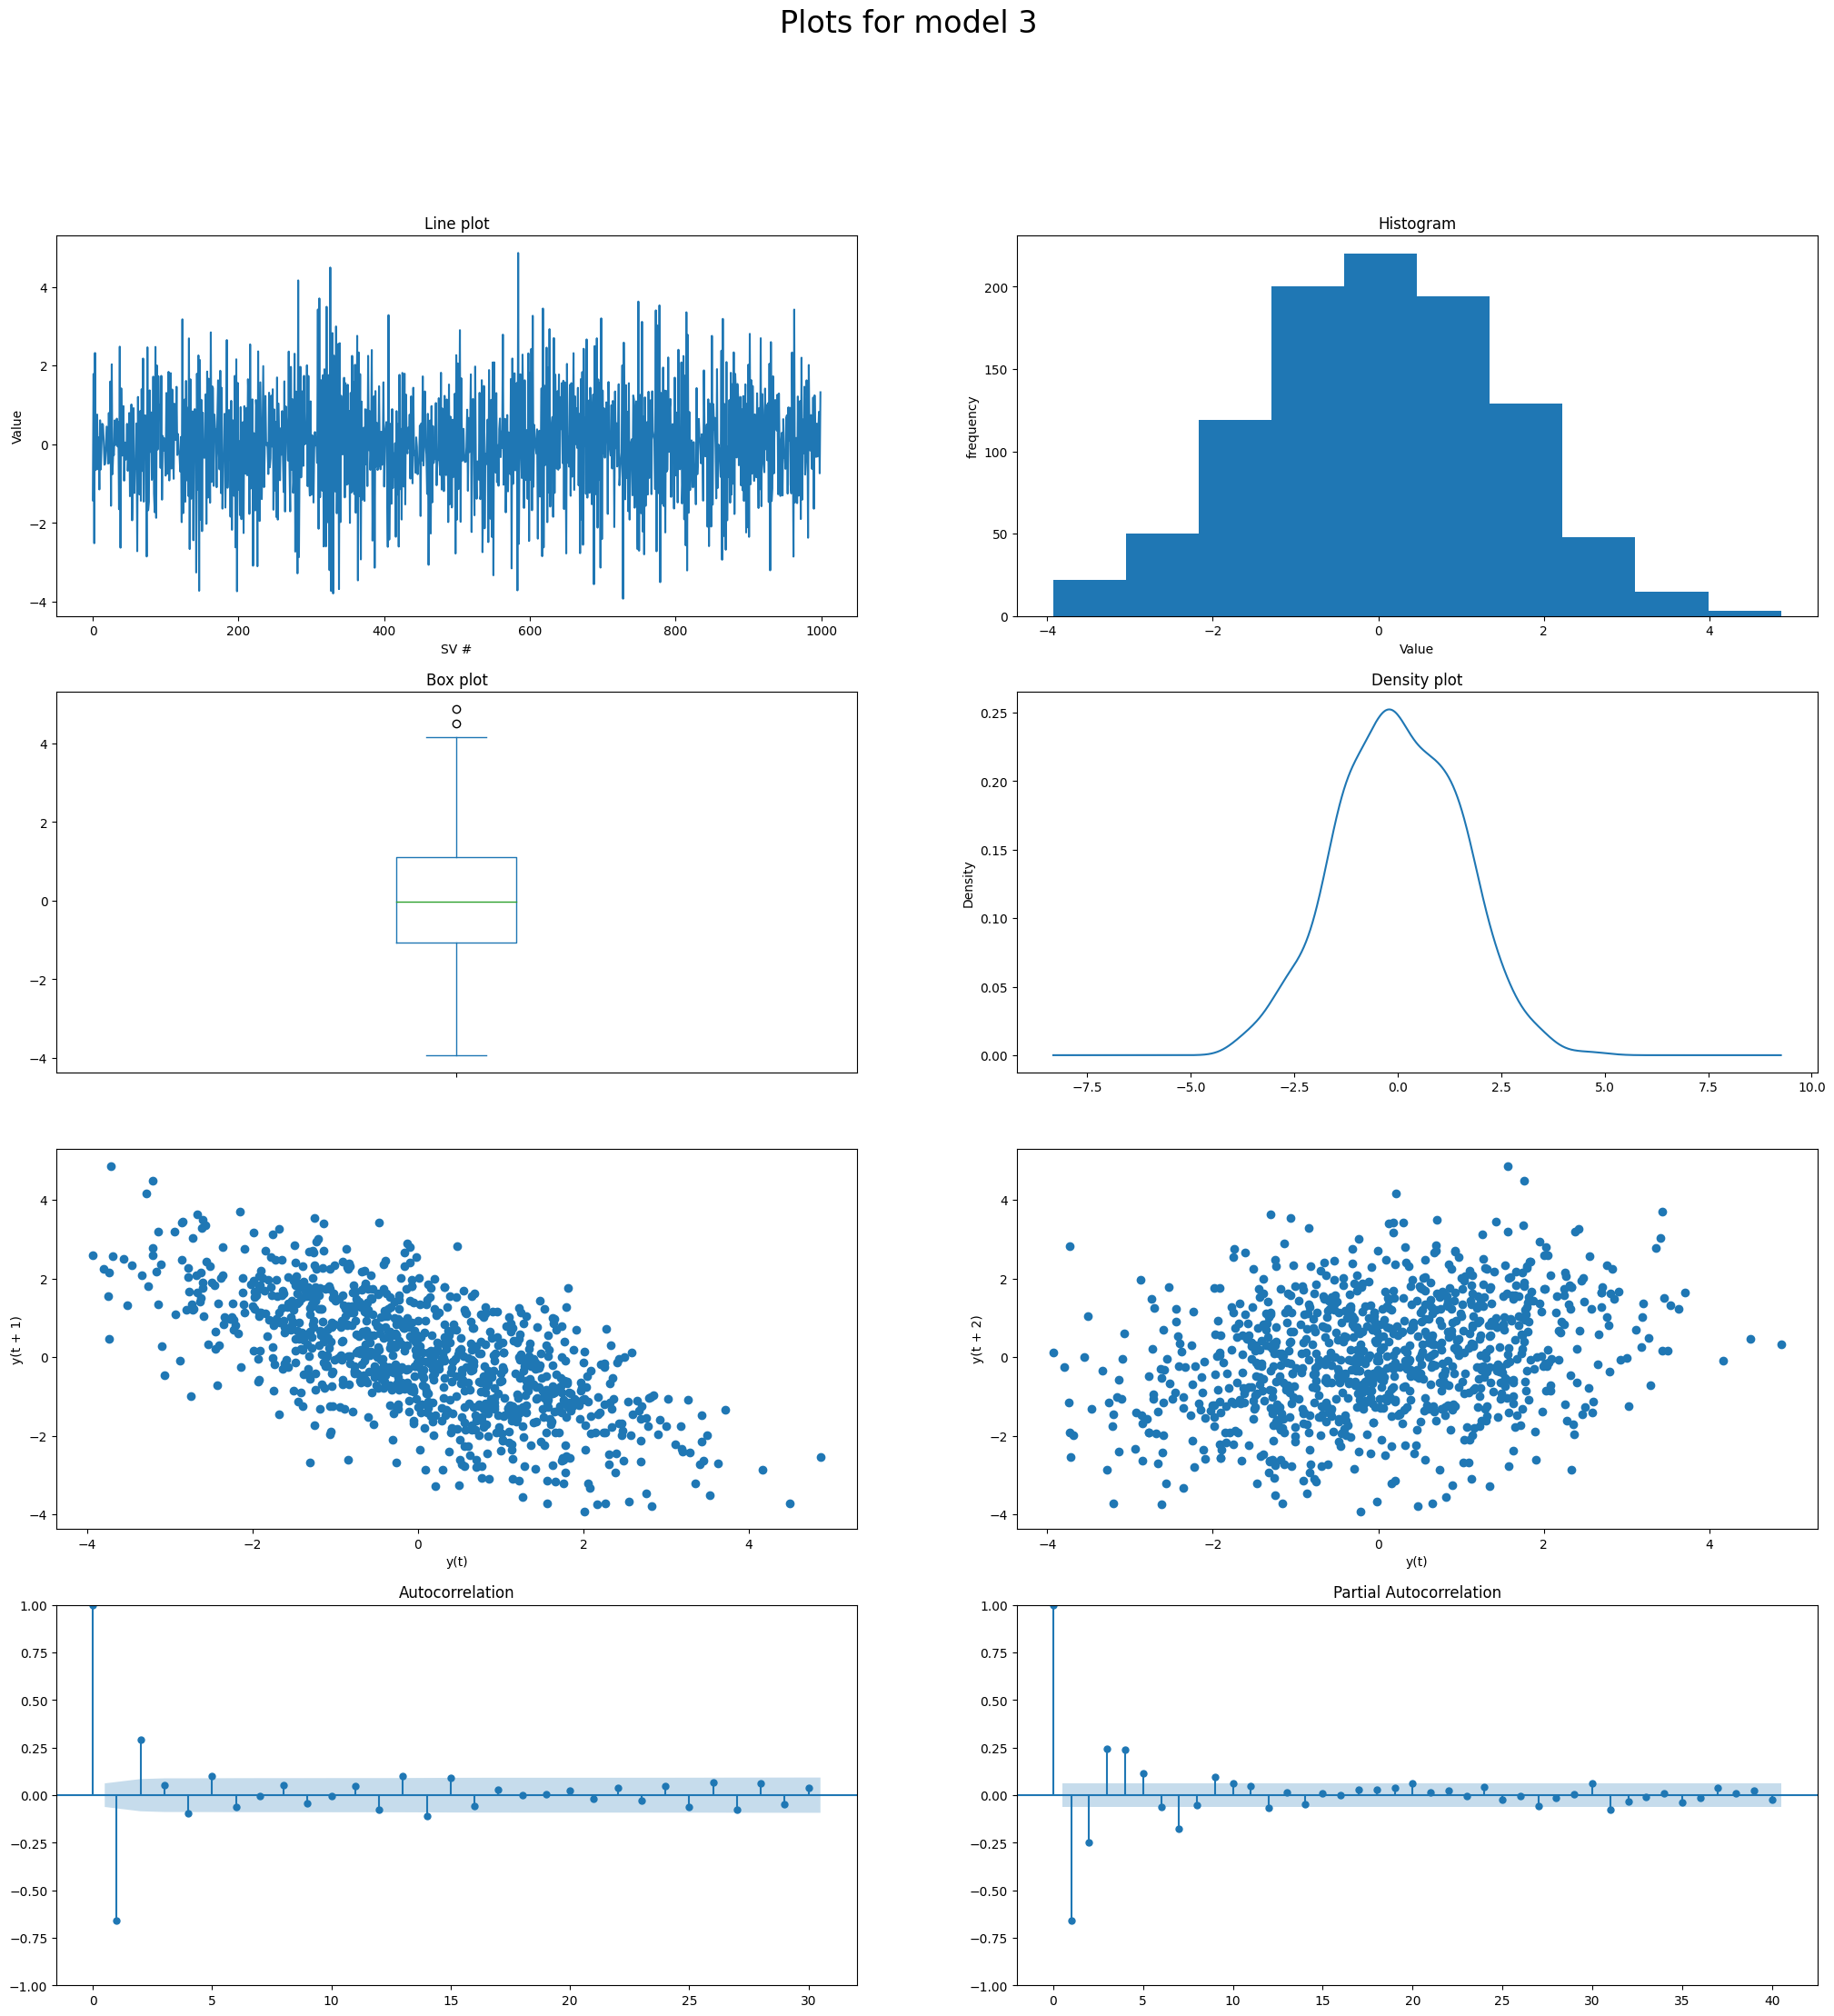

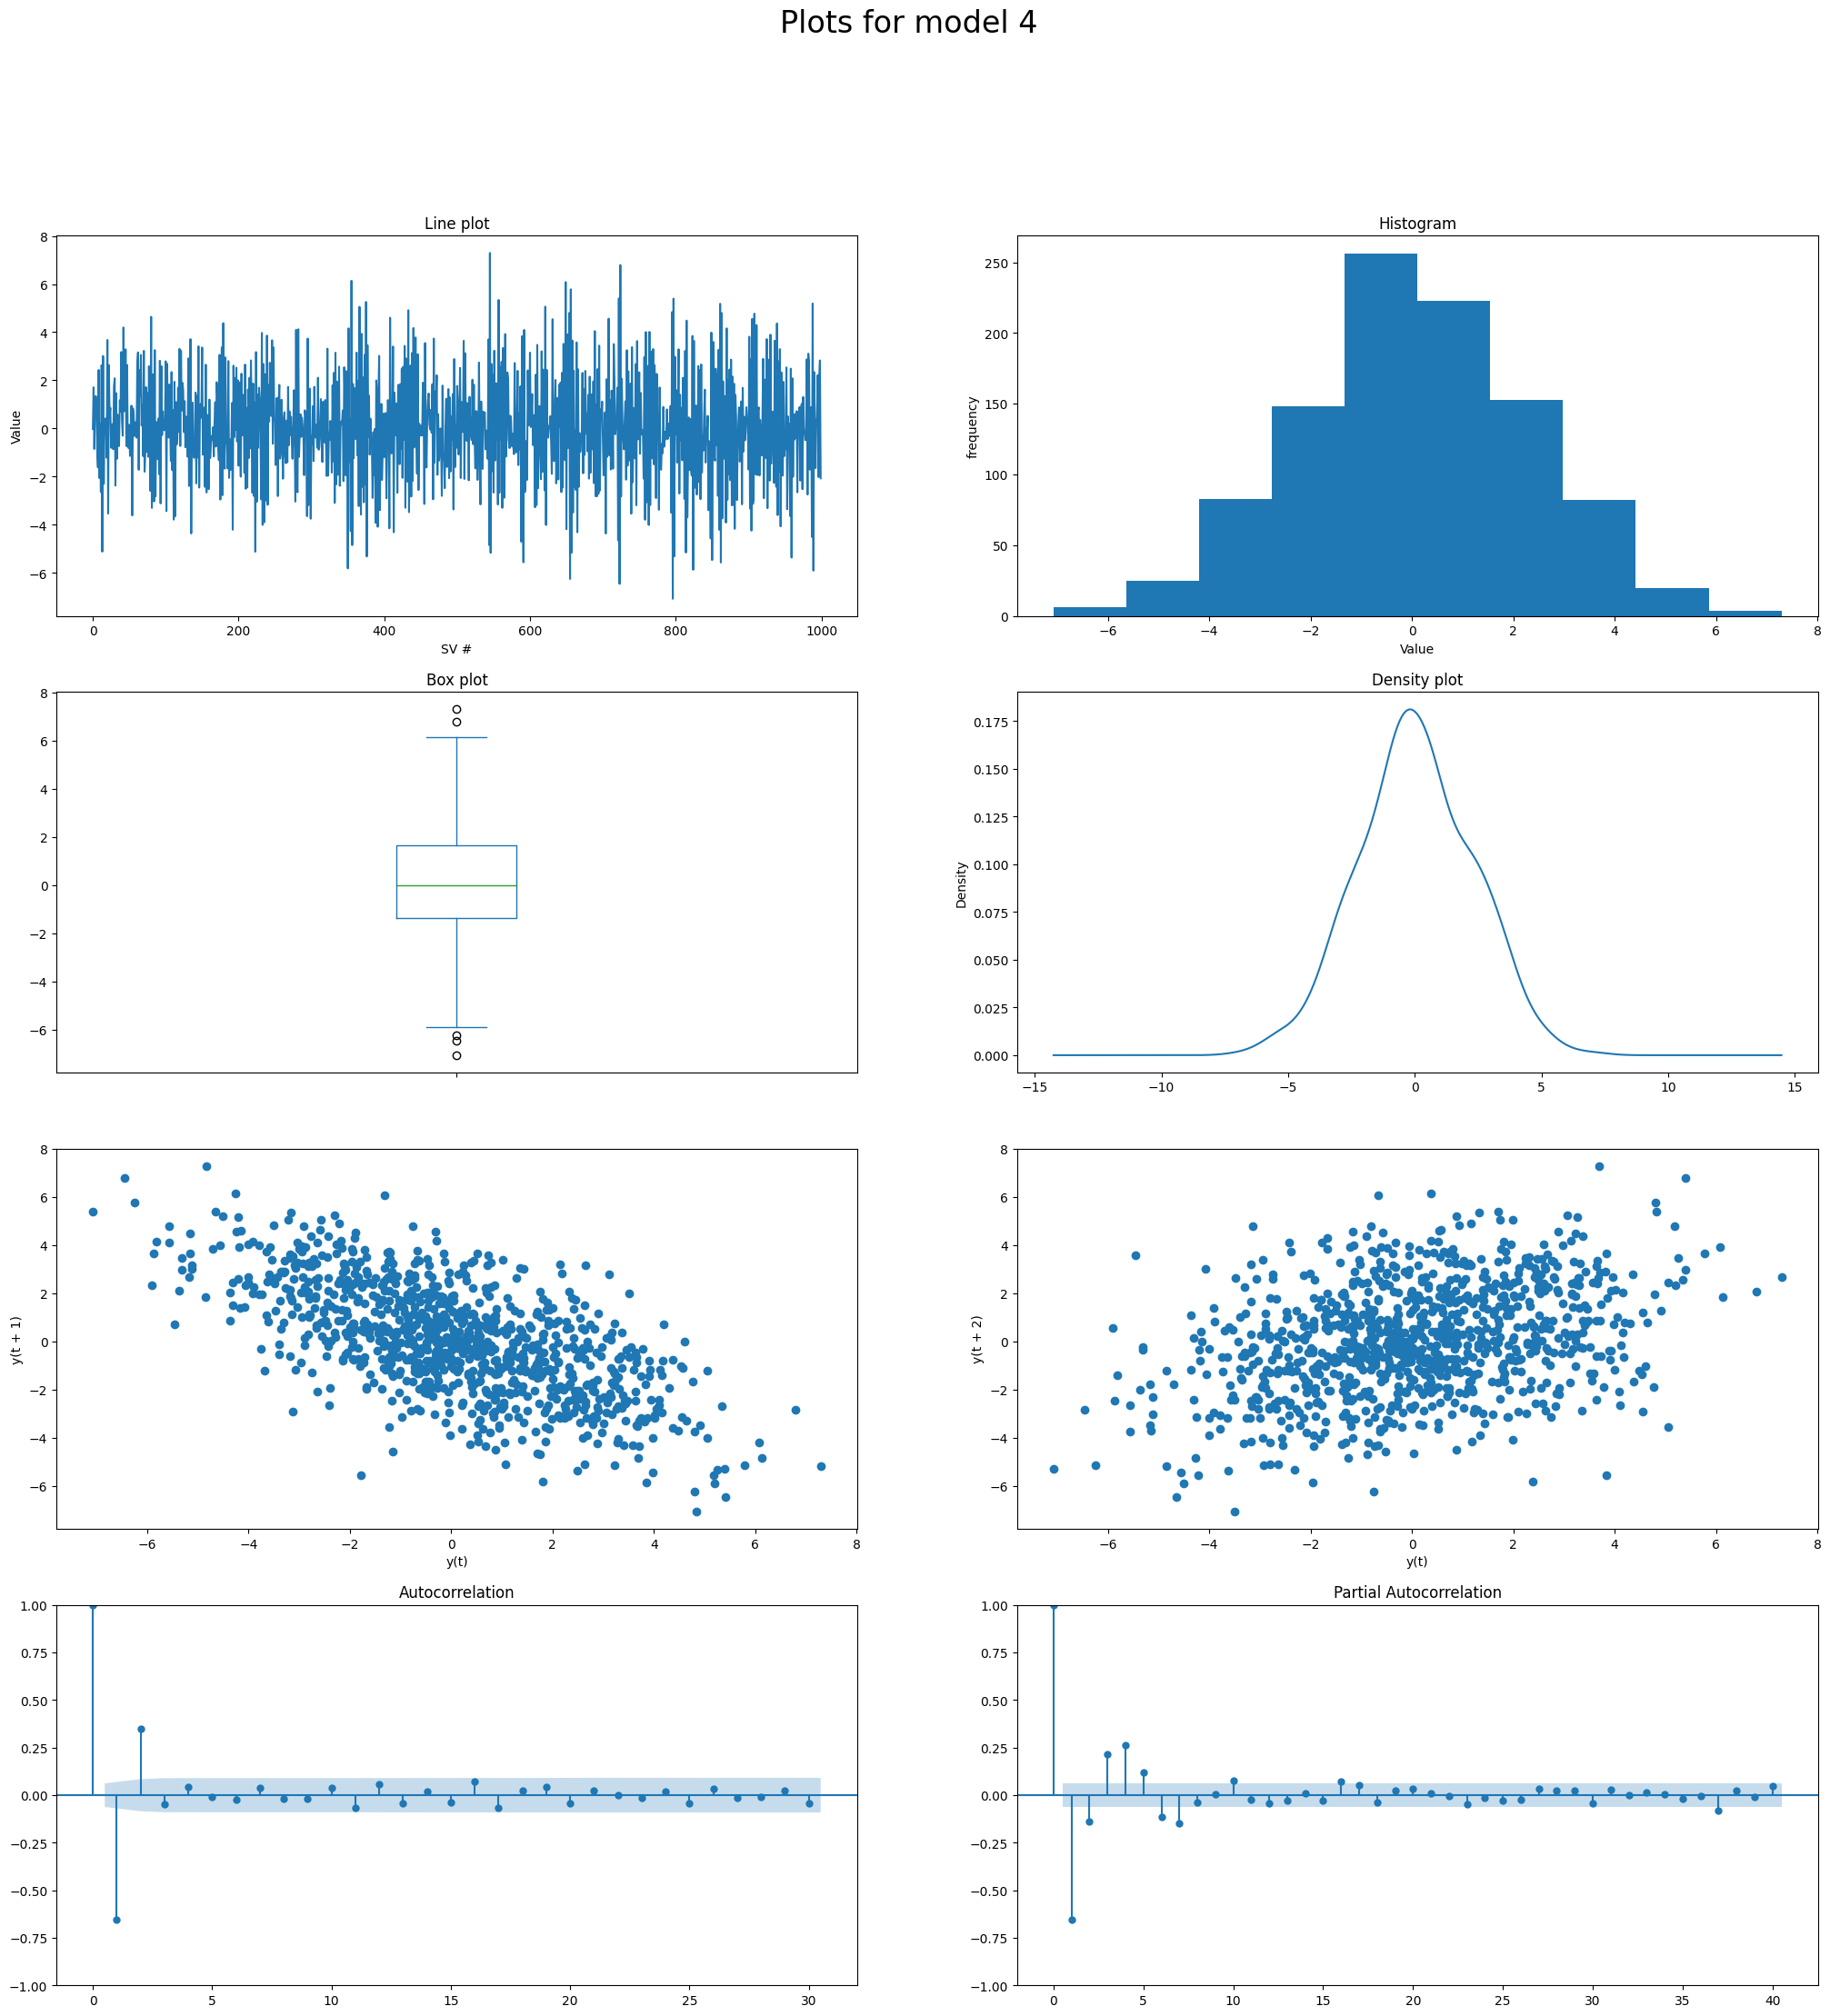

In [178]:
s1, p1 = gen_arma(lagcoeffs_ma=[-2], nsample=1000)
s2, p2 = gen_arma(lagcoeffs_ma=[-0.5], nsample=1000)
s3, p3 = gen_arma(lagcoeffs_ma=[-4/5, 16/25], nsample=1000)
s4, p4 = gen_arma(lagcoeffs_ma=[-5/4, 25/16], nsample=1000)

plot_all(Series(s1), lags=40, title="Plots for model 1");
plot_all(Series(s2), lags=40, title="Plots for model 2");
plot_all(Series(s3), lags=40, title="Plots for model 3");
plot_all(Series(s4), lags=40, title="Plots for model 4");

print("Is process 1 invertible?", p1.isinvertible)
print("Is process 2 invertible?", p2.isinvertible)
print("Is process 3 invertible?", p3.isinvertible)
print("Is process 4 invertible?", p4.isinvertible)

# Task 4 - Stationarity, ACF and PACF of ARMA models

### Judge whether each time series is stationary or not, by visual inspection.
- First time series seems to be stationary, just that there is one small variation in the line plot for the current output. 
- Second time series is clearly stationary. 
- Third time series could be stationary, but there are some patterns that could imply a non-stable mean. 
- Fourth time series is probably not stationary, there is a quite significat pattern where the variance is large then small then large again, despite the mean being stationary.

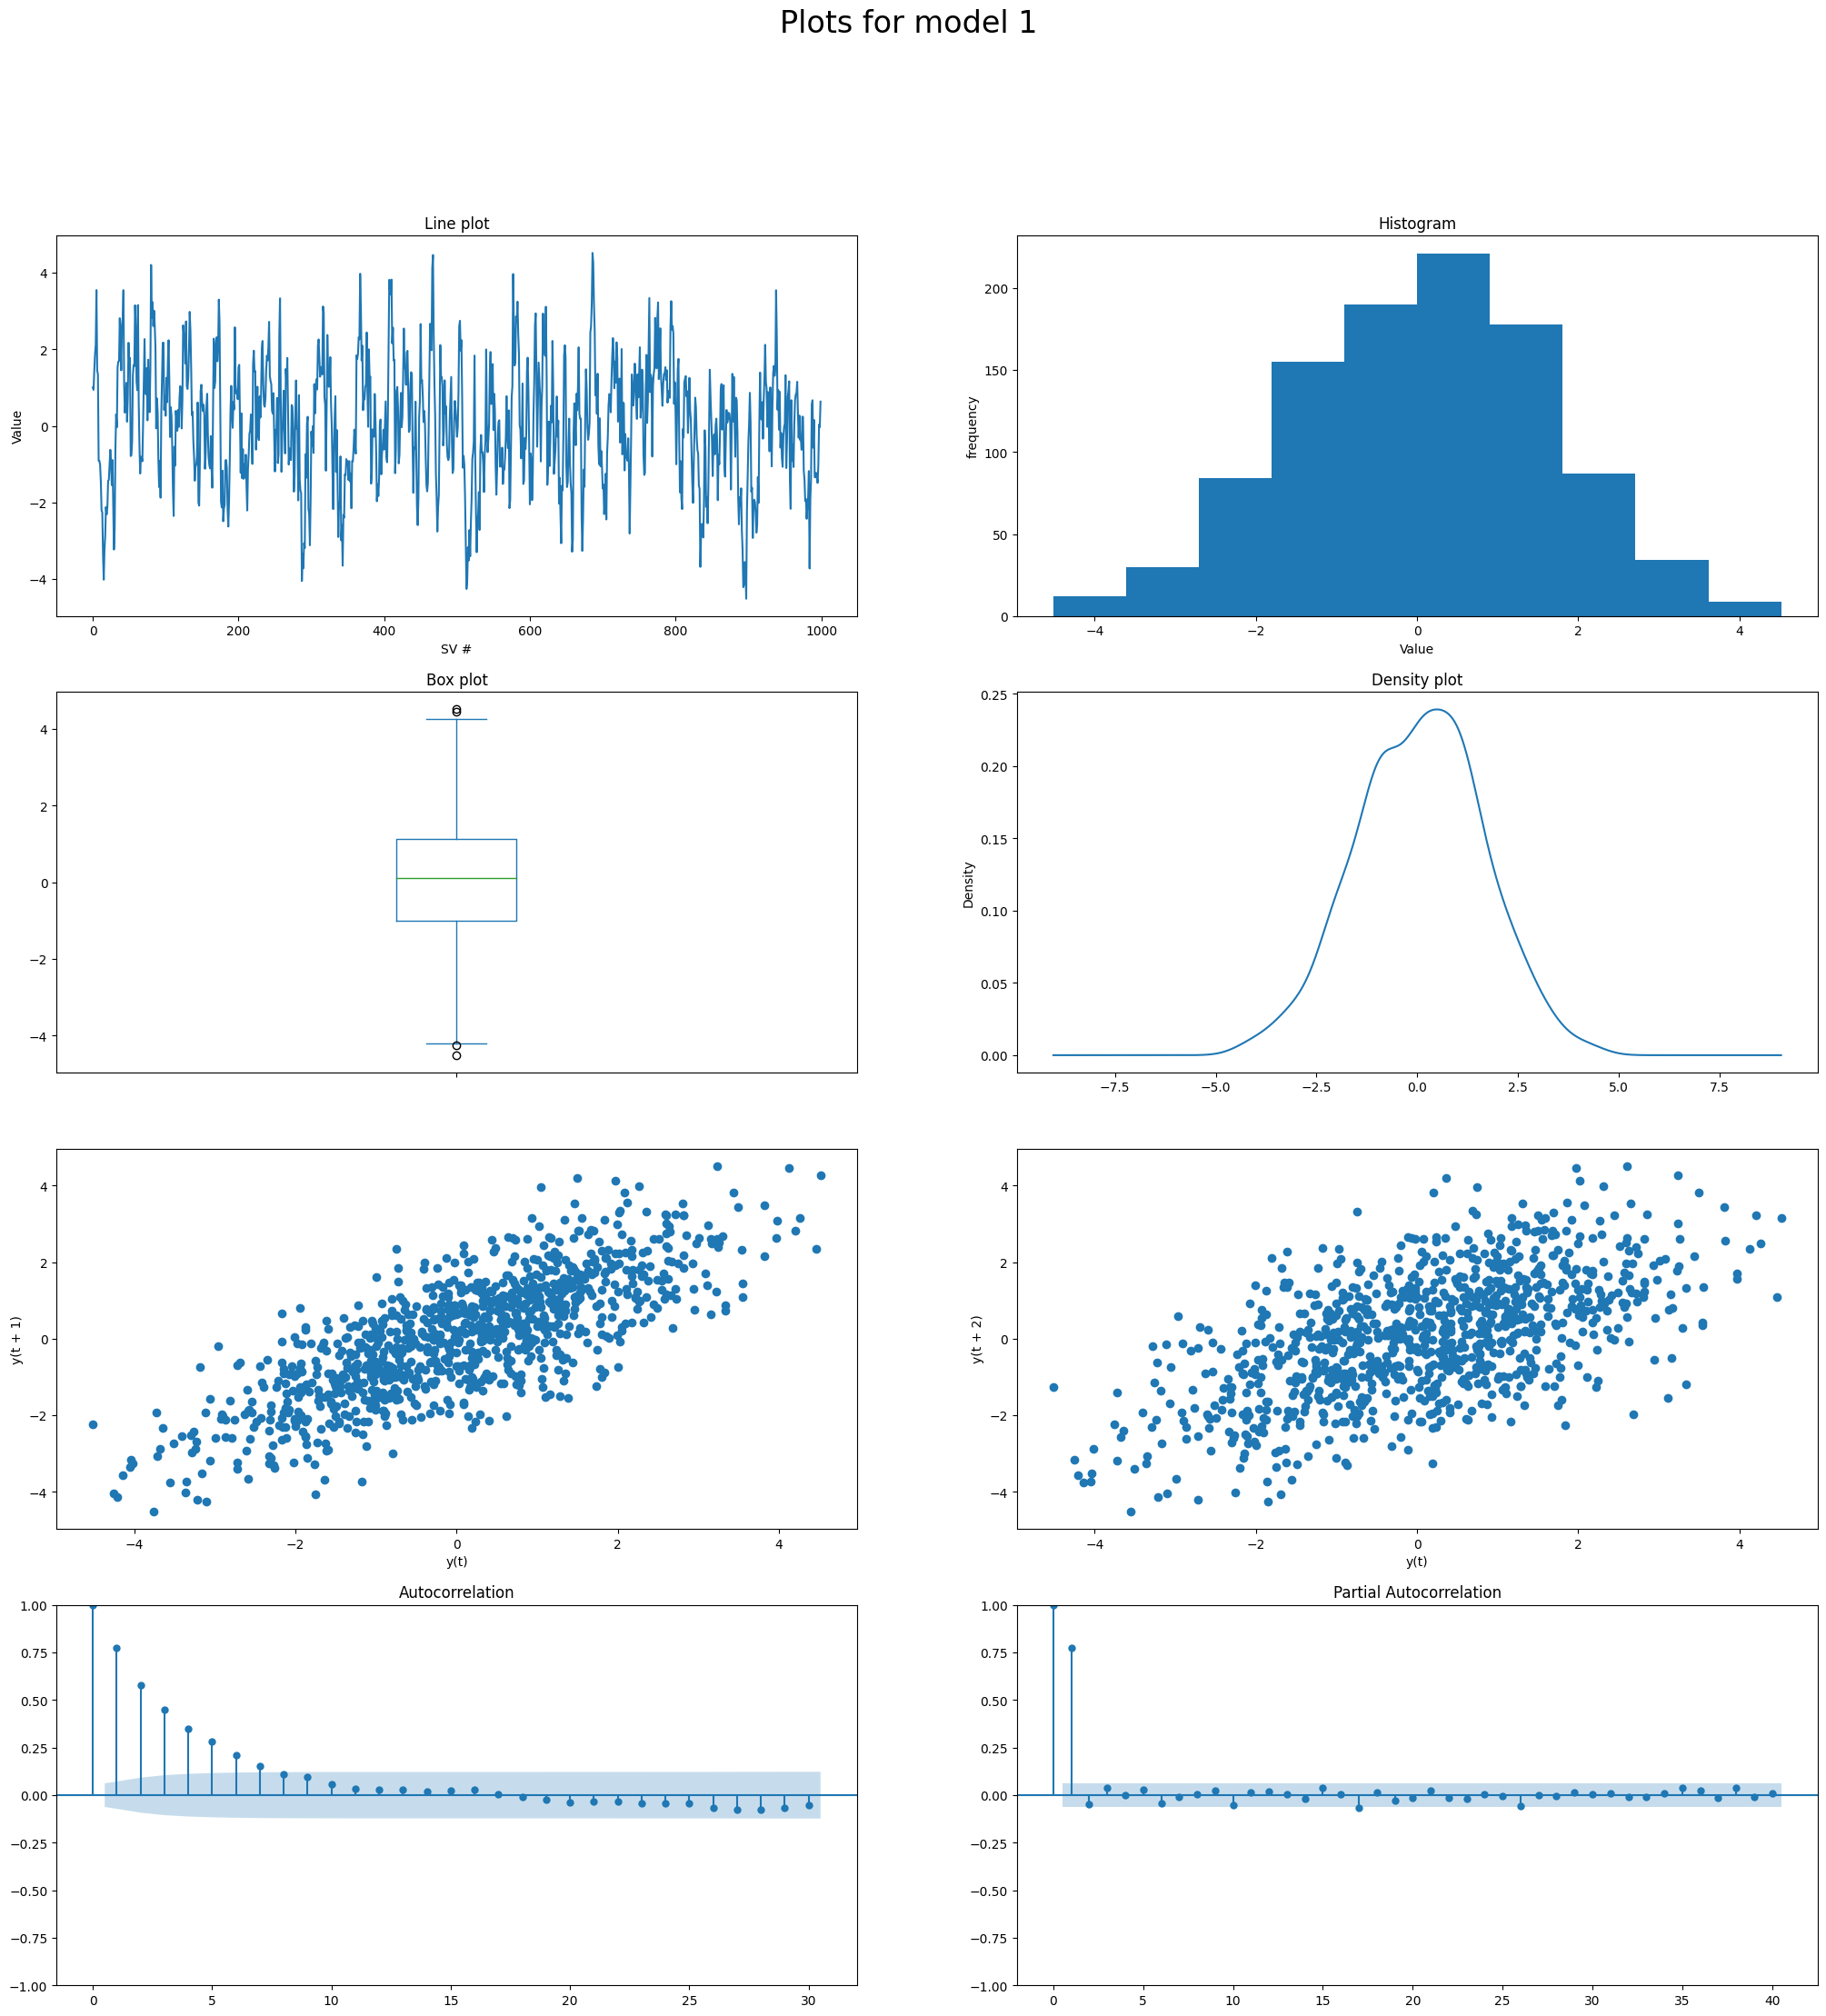

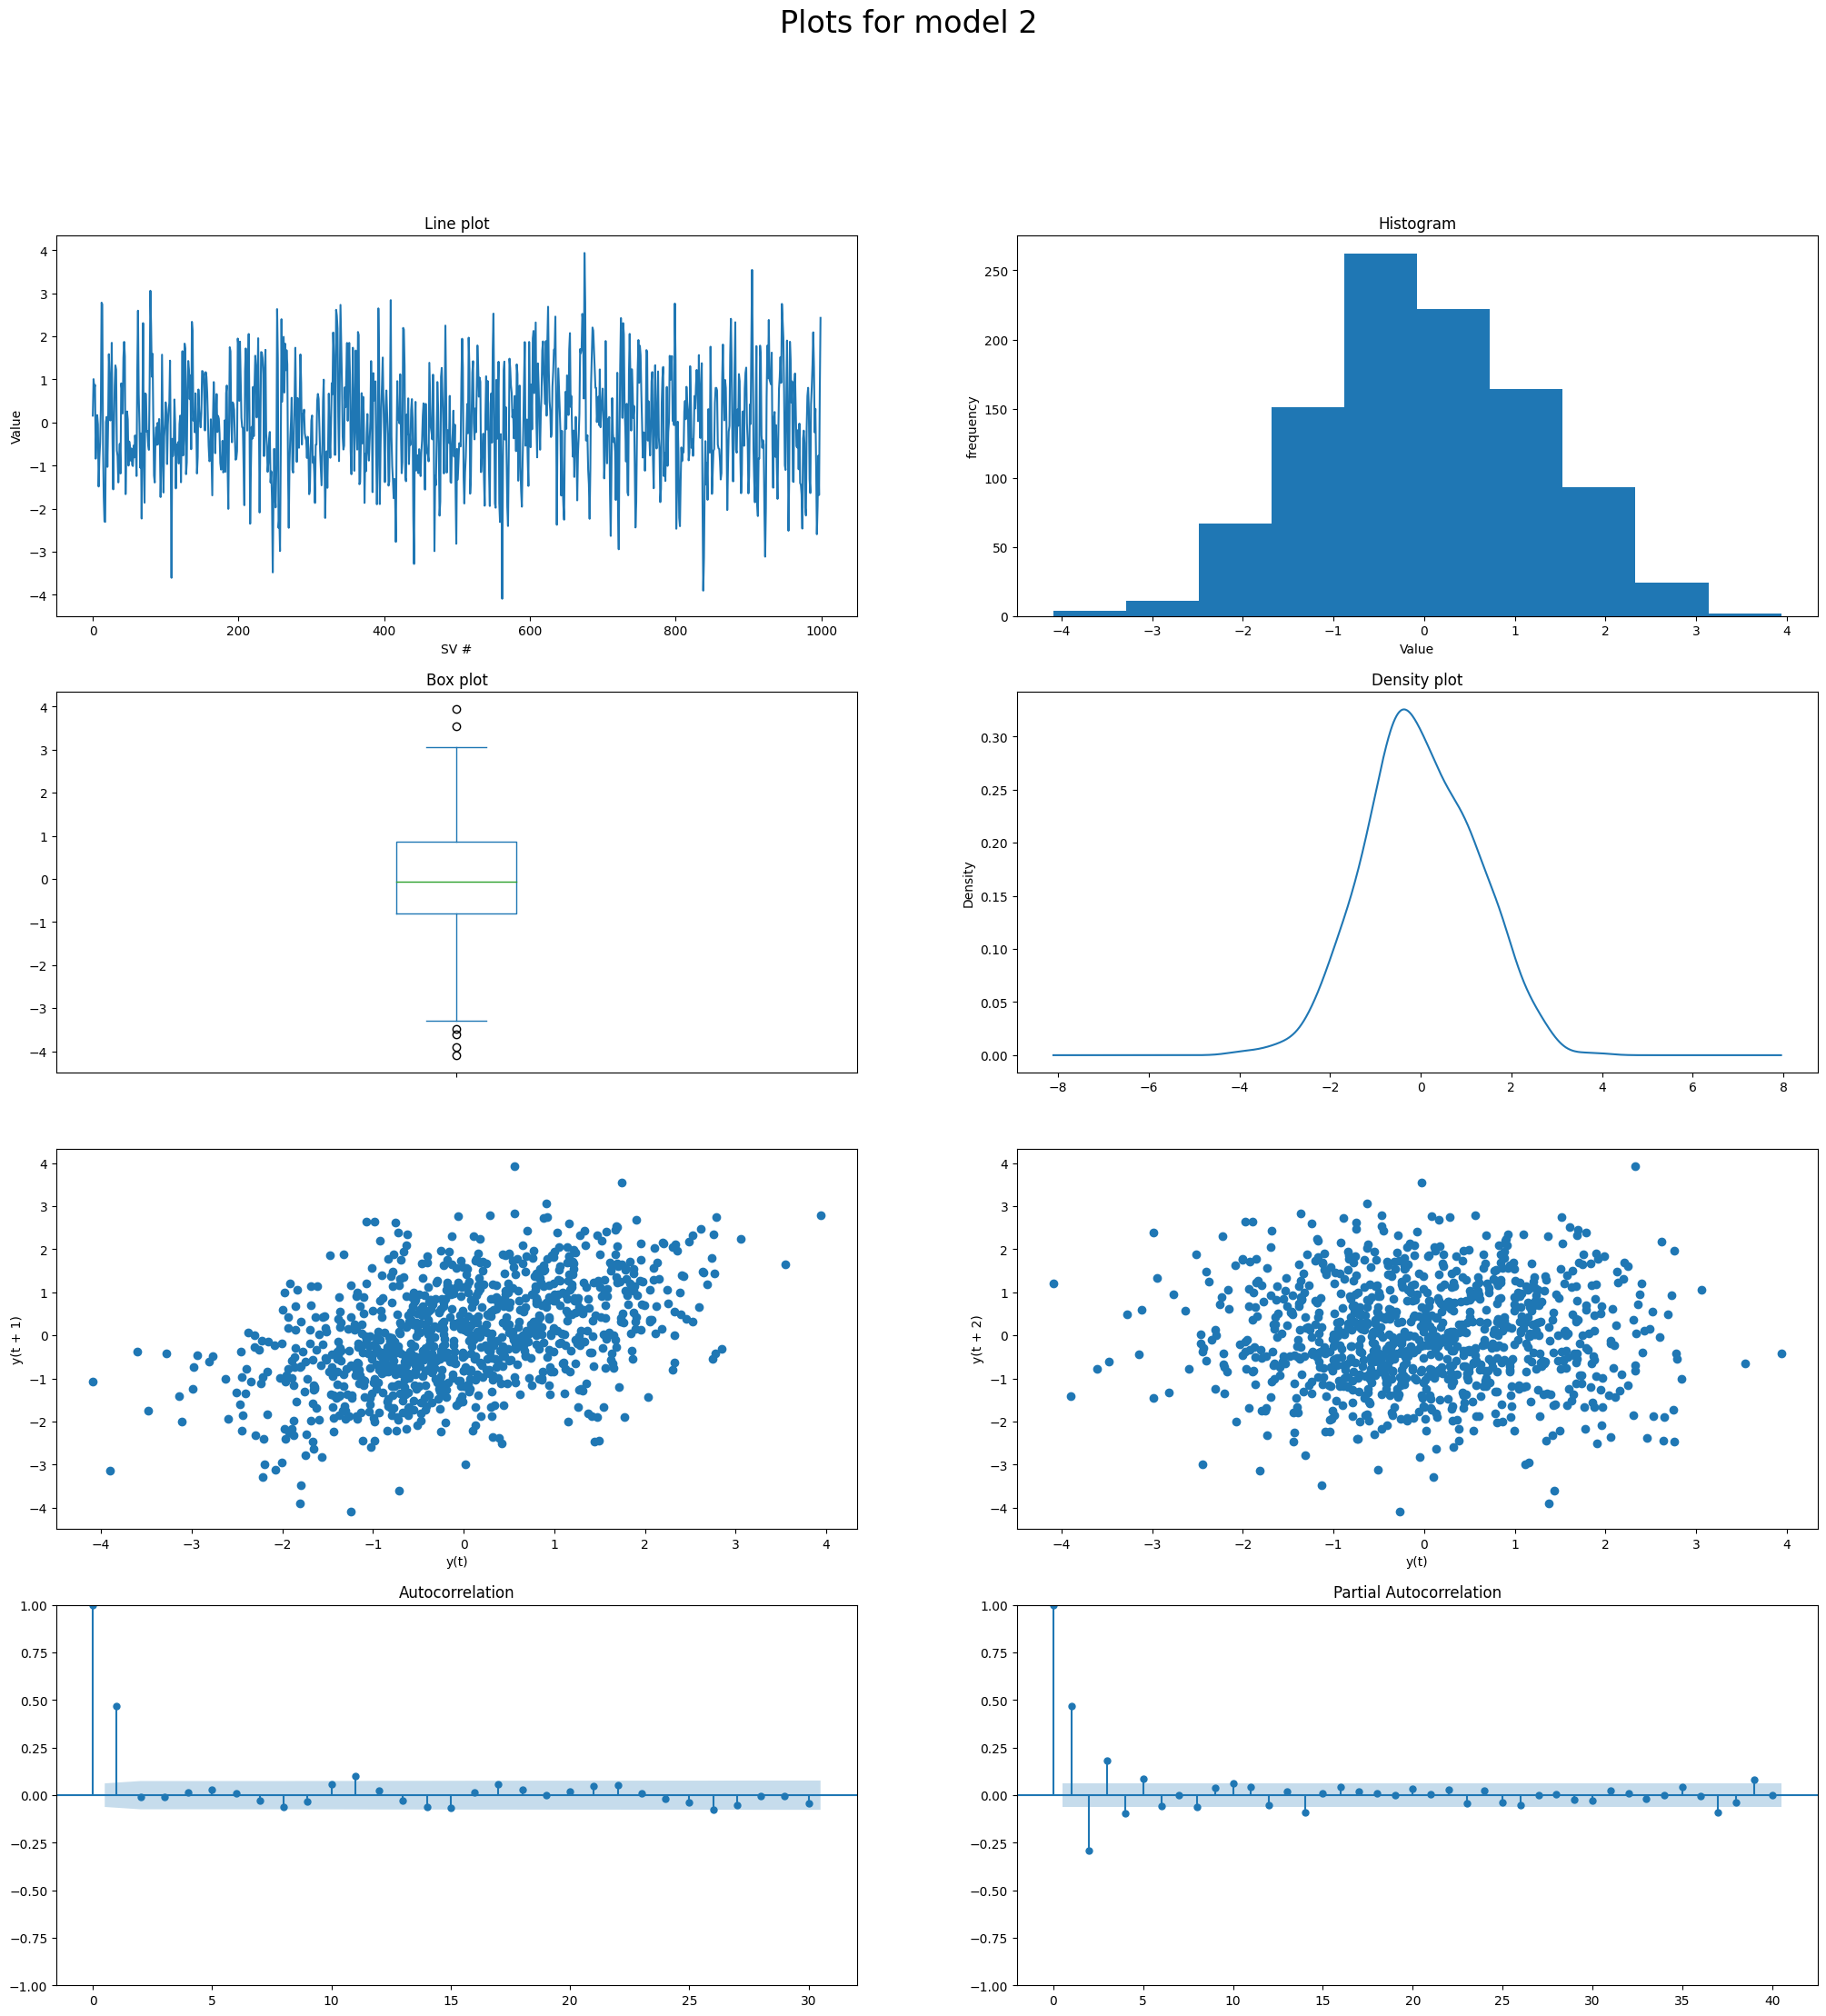

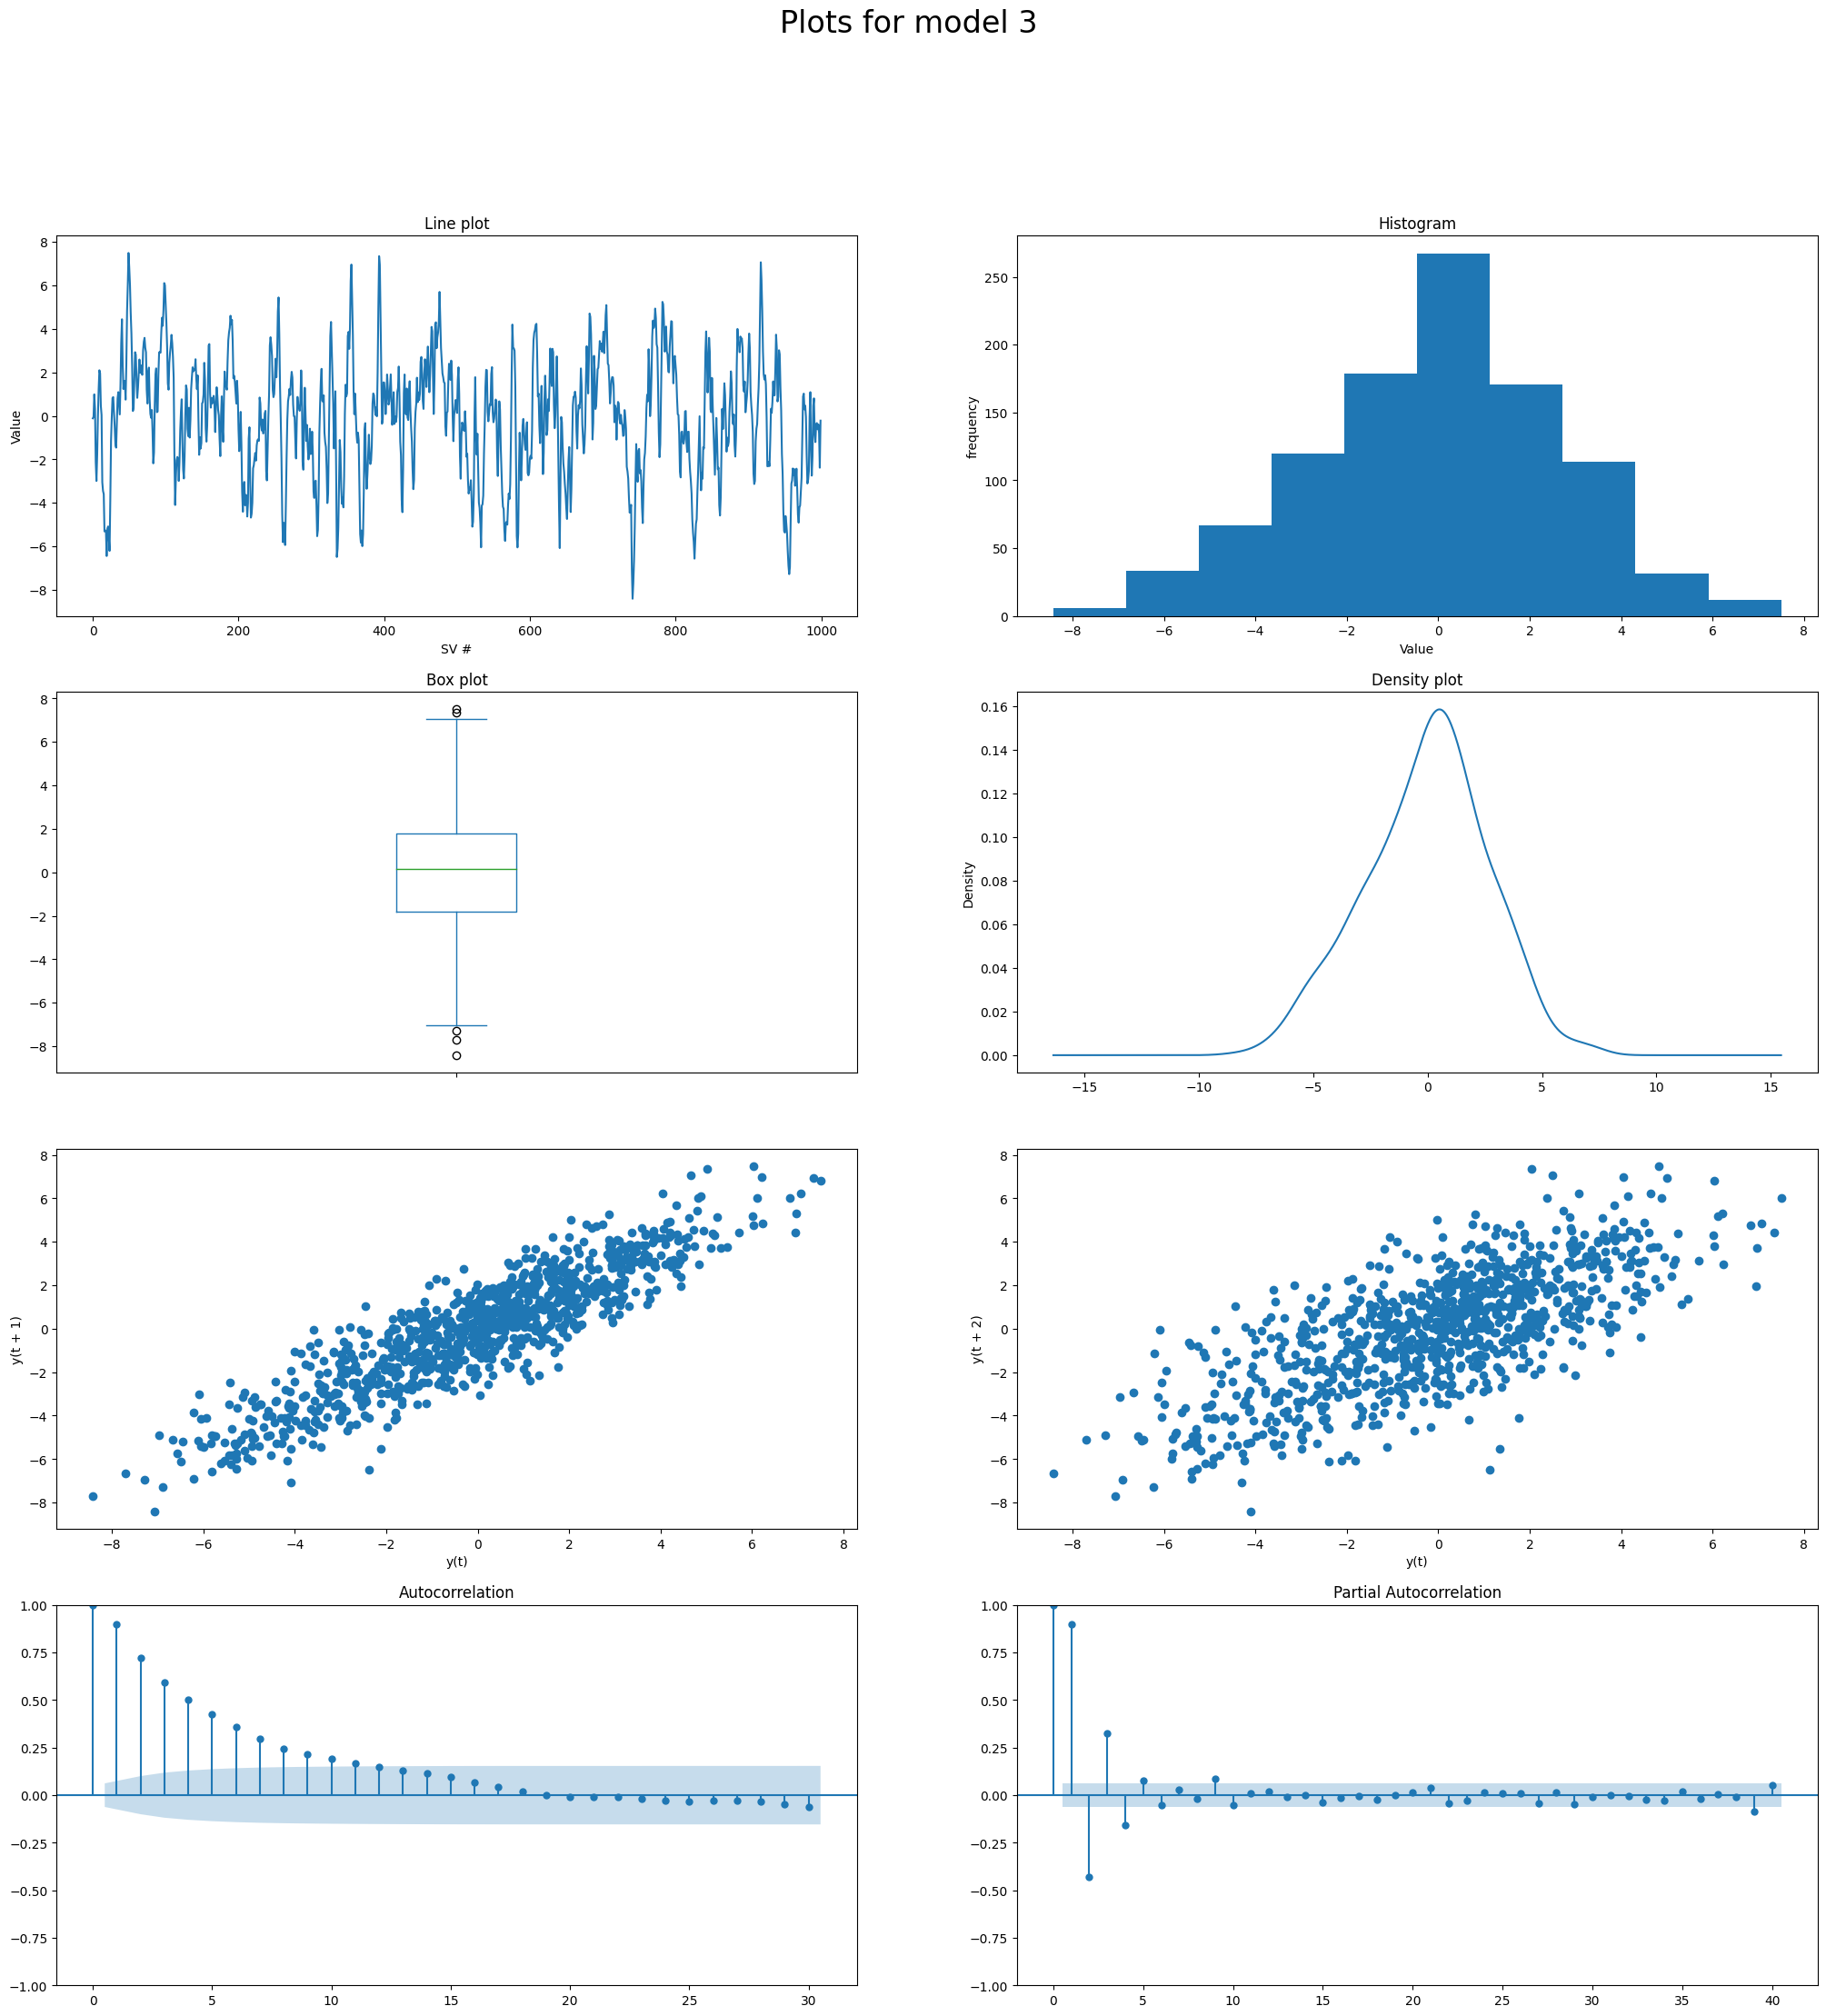

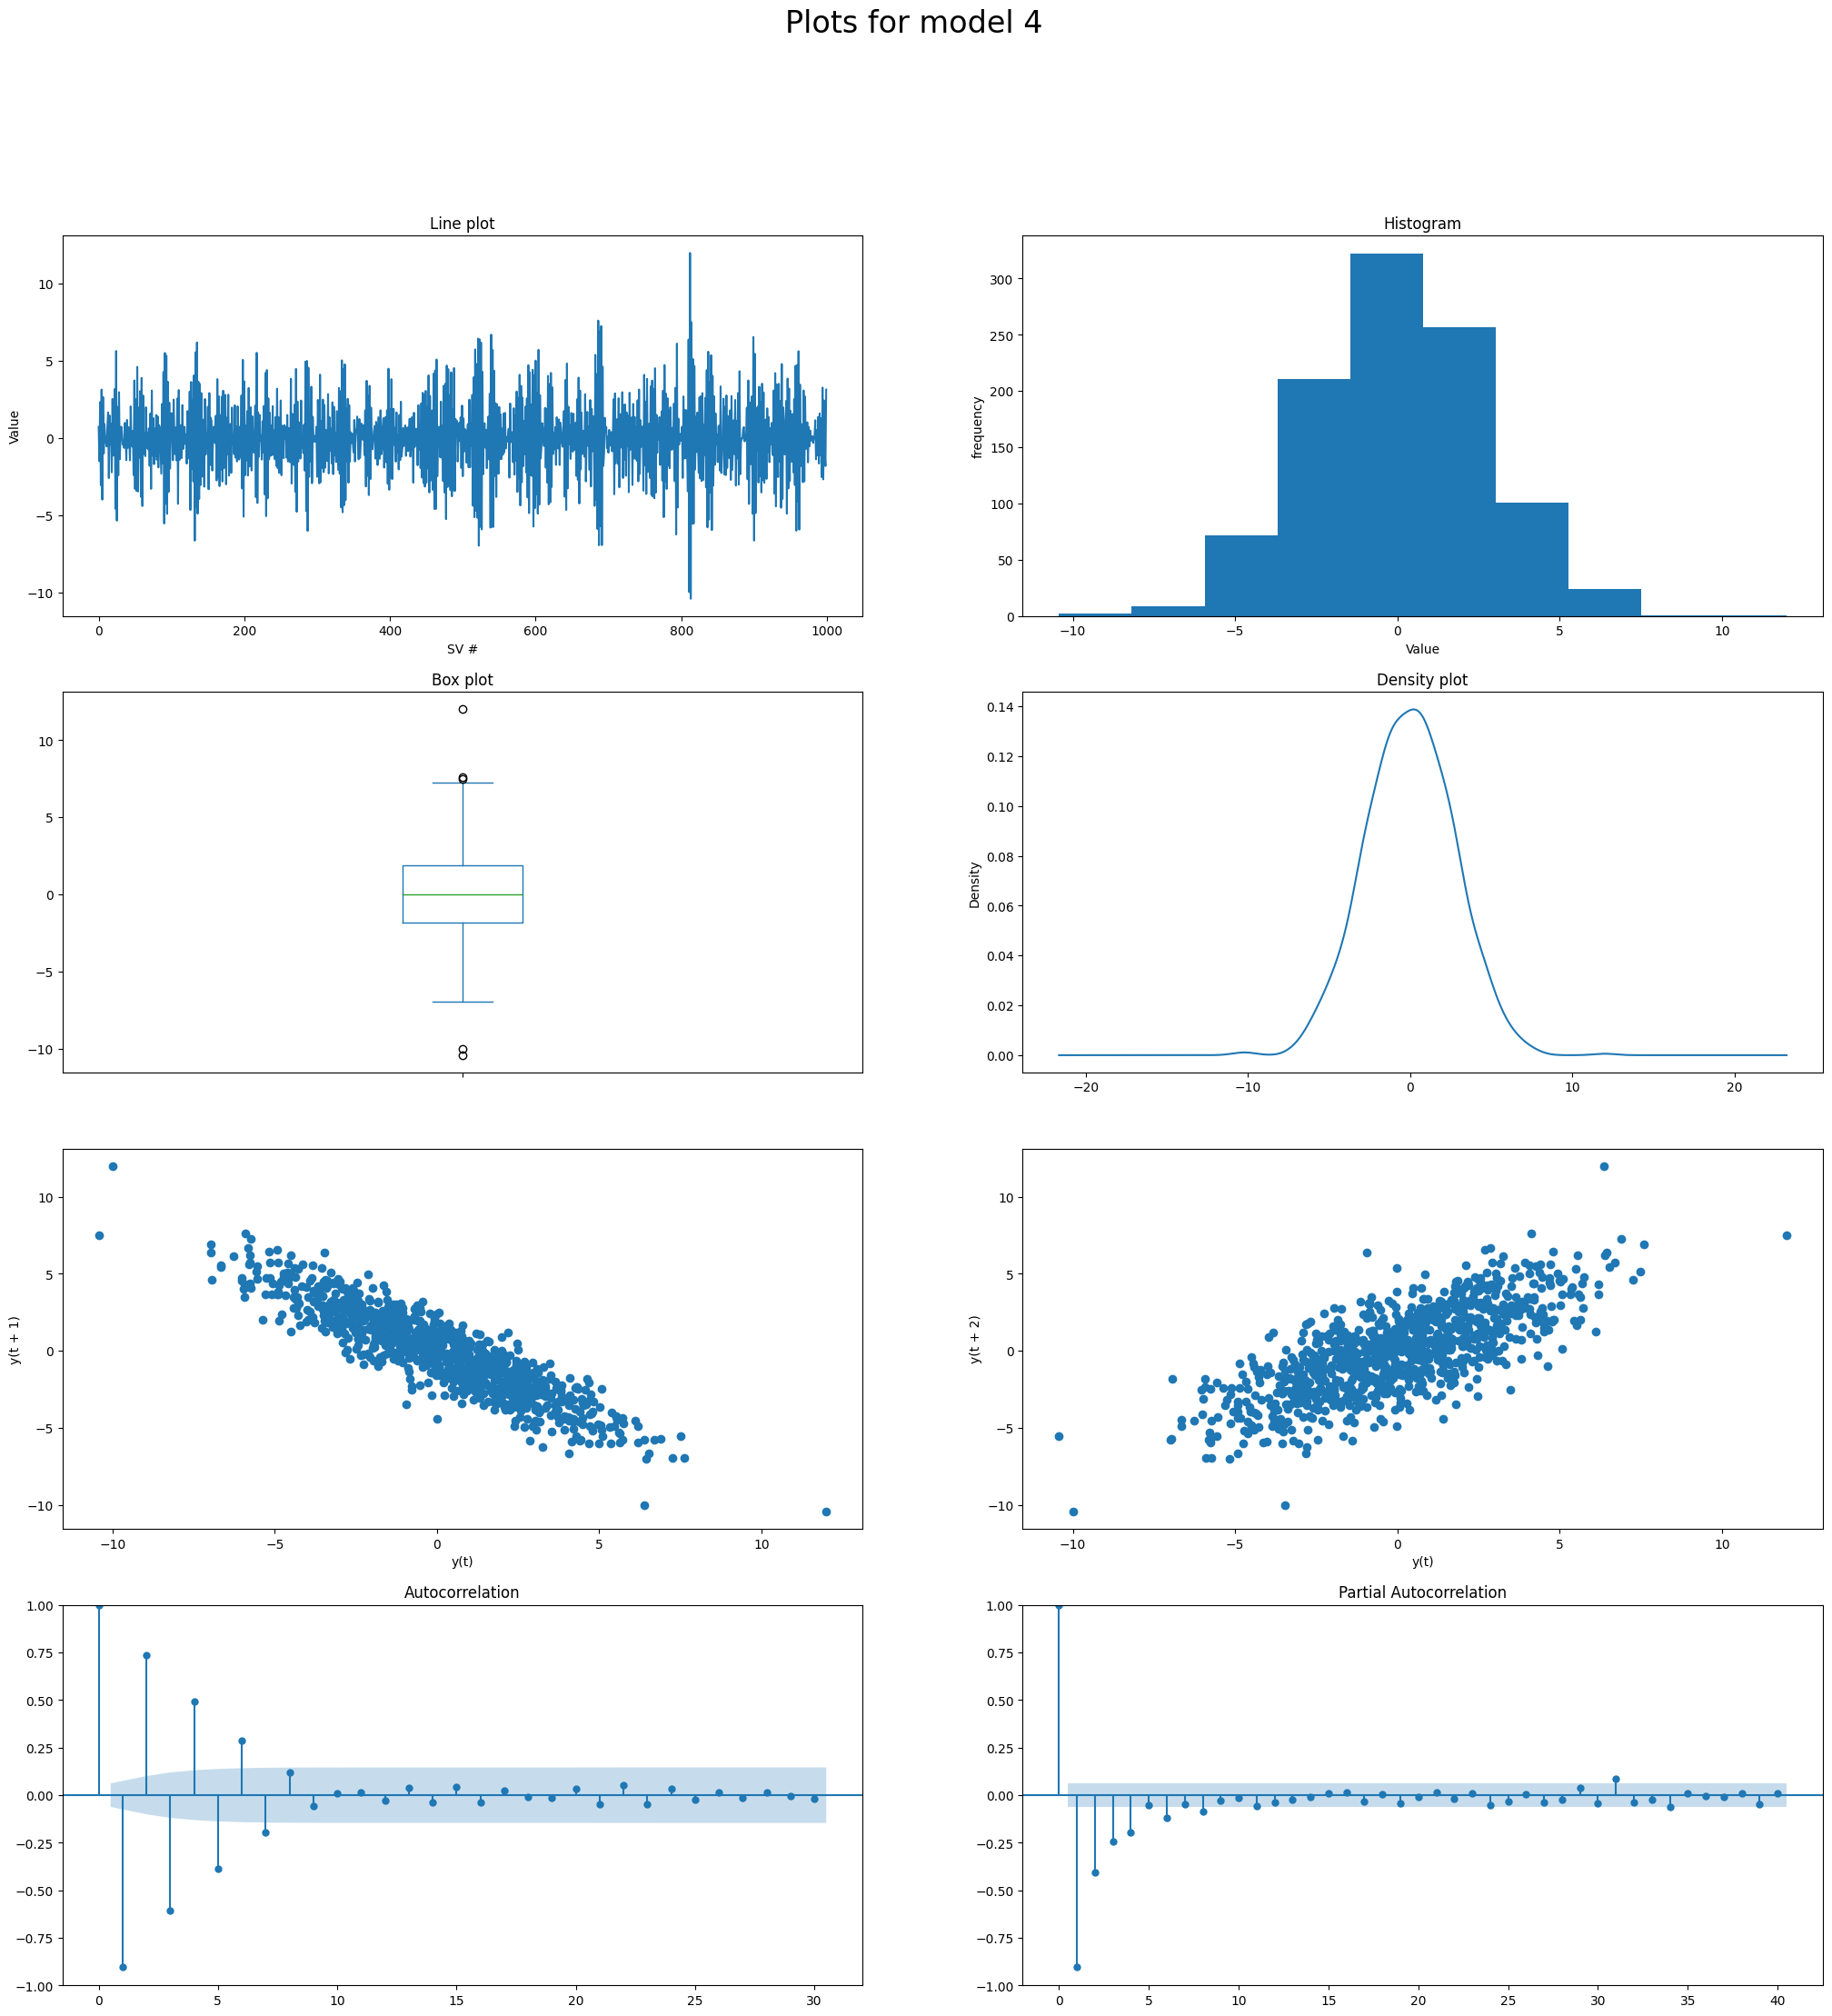

In [46]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8], nsample=1000)
s2, p2 = gen_arma(lagcoeffs_ma=[0.7], nsample=1000)
s3, p3 = gen_arma(lagcoeffs_ar=[0.8], lagcoeffs_ma=[0.7], nsample=1000)
s4, p5 = gen_arma(lagcoeffs_ar=[-0.8], lagcoeffs_ma=[-0.7], nsample=1000)

plot_all(Series(s1), lags=40, title="Plots for model 1");
plot_all(Series(s2), lags=40, title="Plots for model 2");
plot_all(Series(s3), lags=40, title="Plots for model 3");
plot_all(Series(s4), lags=40, title="Plots for model 4");

### Use the ADF test method to judge whether each time series is stationary or not. Do the results match your visual inspection?

The results from the adf test shows that the visual inspection was correct, and also verified that the uncertainty about model 1 being stationary.

In [47]:
adfuller_test(Series(s1))
adfuller_test(Series(s2))
adfuller_test(Series(s3))
adfuller_test(Series(s4))

------------------------------
ADF Statistic: -11.116788227565683
p-value: 3.546699916128358e-20
Critial Values:
1%, -3.4369193380671
5%, -2.864440383452517
10%, -2.56831430323573
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significance level: True
Stationary? True
------------------------------

------------------------------
ADF Statistic: -8.569119915818048
p-value: 8.289729703485636e-14
Critial Values:
1%, -3.4369994990319355
5%, -2.8644757356011743
10%, -2.5683331327427803
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significance level: True
Stationary? True
------------------------------

------------------------------
ADF Statistic: -6.770461096897982
p-value: 2.6499660930854315e-09
Critial Values:
1%, -3.436972562223603
5%, -2.864463856182476
10%, -2.5683268054280175
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significa

### Call the corresponding statsmodels functions to judge if each ARMA process is stationary and invertible.

The stationary property of the processes correspond to the adf test and the visual inspection.

In [48]:
print(f"Is model 1: invertible? {p1.isinvertible} | stationary? {p1.isstationary}")
print(f"Is model 2: invertible? {p2.isinvertible} | stationary? {p2.isstationary}")
print(f"Is model 3: invertible? {p3.isinvertible} | stationary? {p3.isstationary}")
print(f"Is model 4: invertible? {p4.isinvertible} | stationary? {p4.isstationary}")

Is model 1: invertible? True | stationary? True
Is model 2: invertible? True | stationary? True
Is model 3: invertible? True | stationary? True
Is model 4: invertible? False | stationary? True


### Draw histogram, density plot, and box plot for each time series with 1000 data points. Are there any outliers? Why?
There are outliers for all box plots, but they are equally divided between over and under the confidence intervals to it should not affect the stationarity results. These outliers are produced because of the error distribution that can sometimes yield values outside the confidence interval by nature, and since that's not common they become outliers.

### Draw lag-1 and lag-2 plots for each time series. Do you observe any auto-correlation from the lag plots?
The second ARMA model does not show any particular signs of autocorrelation. However, the three other models show clear diagonal patterns. Model 4 might indicate seasonality because lag-1 slopes upwards, and lag-2 downwards, meanwhile model 1 and 3 show an increasing autocorrelation pattern in the data.

### Questions
- What characteristics can you observe from the ACF, PACF graphs of the AR(p) model?
The auto-correlation is high for lags 1 and 2 in the PACF plot, then they are not of any significance. The ACF plot shows decaying auto-correlation until lag 500, after that there is no significant observations.
- What characteristics can you observe from the ACF, PACF graphs of the MA(q) model?
The PACF plot shows great auto-correlation for until around lag 5, then not of significance for higher lags. The ACF is almost never outside the confidence interval, and the few occurences are very close to still being random. 
- What characteristics can you observe from the ACF, PACF graphs of the ARMA(p, q) models?
Both PACF graphs are quite significant until the lag=10 mark. Both ACFs show strong auto-correlation that does not even seem to disappear with larger lag, but with interval based correlation that surpasses the confidence intervals.

# Task 5 - ARIMA modeling and prediction

### **Step 1.** Randomness test. Check if the sequence is random using line plot, lag-1 plot and Ljung-Box test. If it is, you are done, otherwise continue to the next steps.

Ljungbox results:
       lb_stat     lb_pvalue
1    65.914271  4.709690e-16
2   114.149261  1.632311e-25
3   151.955524  9.974838e-33
4   189.507131  6.764012e-40
5   220.874422  9.652744e-46
6   253.060924  9.093751e-52
7   276.676346  5.742962e-56
8   301.607312  1.873081e-60
9   324.274857  1.832207e-64
10  350.976775  2.472290e-69


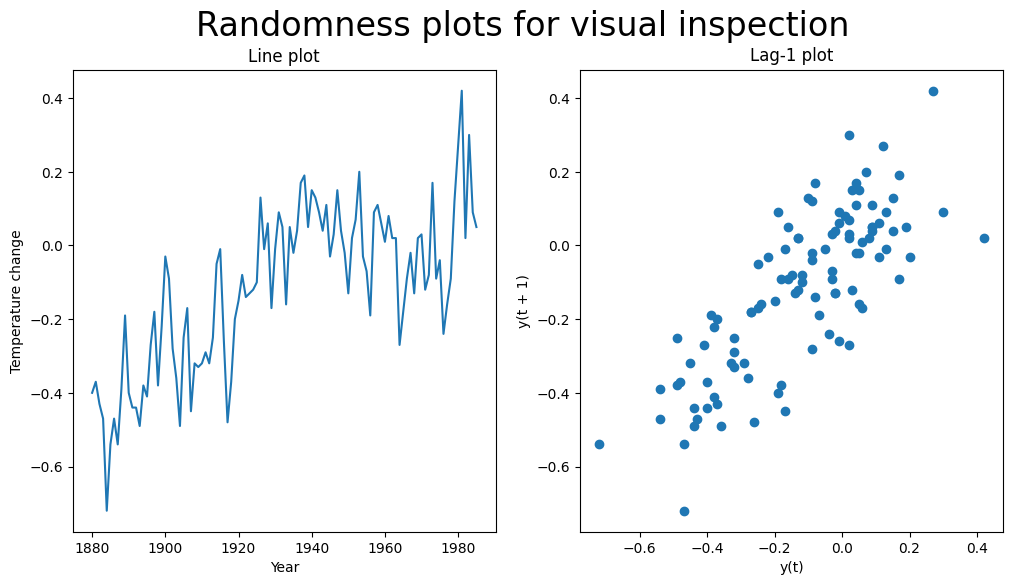

In [118]:
data = read_csv('tempchange.csv')
series = Series(data=data['temperature change'].values, index=data['year'].values)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.subplots_adjust()
fig.suptitle("Randomness plots for visual inspection", fontsize=24)
series.plot(ax=axes[0], kind='line', title='Line plot', xlabel='Year', ylabel='Temperature change')
plotting.lag_plot(series, ax=axes[1], lag=1)
axes[1].text(0.5, 1.02, 'Lag-1 plot', ha='center', fontsize=12, transform=axes[1].transAxes)

# ljungbox test
ljungbox(series)

As can be observed in the above plots, it is obvious that the time series is not random, the line plot surely has an upwards trend and the lag-1 plot has a quite clear upwards trend. Furthermore, the Ljung-box test results indicate very small pvalues and implies that the null hypothesis (no auto-correlation) should be rejected, i.e. it can be concluded that there is auto-correlation in the time series.

### **Step 2.** Stationarity test and differencing. Test the stationarity of the series. If it is not stationary, use the difference operation to generate a differenced sequence. In this step, you determine the value of d. You may need to do second difference for some time series, if necessary.

In [50]:
adfuller_test(series)

------------------------------
ADF Statistic: -1.9091315185935462
p-value: 0.32777762531438015
Critial Values:
1%, -3.4989097606014496
5%, -2.891516256916761
10%, -2.5827604414827157
------------------------------
Critical values less than adf statistic: 3
p-value is below the 5% significance level: False
Stationary? False
------------------------------



Based on the above adfuller test, the series is not stationary by its original representation. It has to be differenced.

In [51]:
firstorderdiff = series.diff()[1:]
adfuller_test(firstorderdiff)

------------------------------
ADF Statistic: -6.437287387132189
p-value: 1.6408522350645357e-08
Critial Values:
1%, -3.4989097606014496
5%, -2.891516256916761
10%, -2.5827604414827157
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significance level: True
Stationary? True
------------------------------



As can be seen in the second ad-fuller test, the series is now stationary and we can continue to the next step. Also, it is found that parameter $d=1$

### **Step 3.** Model identification. Draw ACF and PACF plots of the sequence. Based on the ACF, PACF graphs, you determine the values for p and q.

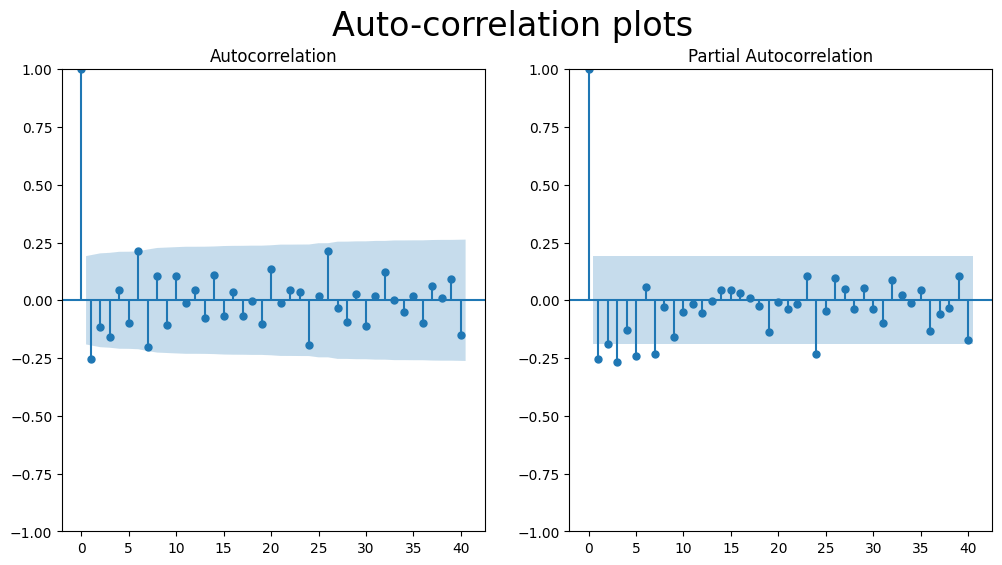

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.subplots_adjust()
fig.suptitle("Auto-correlation plots", fontsize=24)
plot_acf(firstorderdiff, lags=40, ax=axes[0])
plot_pacf(firstorderdiff, lags=40, ax=axes[1], method='ywm');

Based on the ACF graph we can identify the value of $q$ by inspecting when the auto-correlation is close to 0. By this, we can see that the parameter $q = 11$. Likewise we can identify $p = 11$, when the partial auto-correlation is close to 0.

### **Step 4.** Parameter estimation and model optimization. Since there can be multiple models which give good results, you can choose an optimal one based on, for example, the AIC criterion.

In [70]:
auto_arima(firstorderdiff, start_p=2, max_p=13, d=1, start_q=2, max_q=13, seasonal=False, information_criterion='aic')

ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True)

Using the `auto_arima(..)` function, we can estimate relevant parameters. As seen above, the algorithm suggests $p=5$ and $q=2$ for an optimal model using the AIC criterion. This is very far away from the ACF/PACF estimations done in the previous step, so it might have been done incorrectly.

### Step 5. Model validation. This is to determine if the fitted model is acceptable. If not, go back to Step 4. This is done through in-sample prediction. With in-sample prediction, you can generate a remainder sequence so as to test if the fitted model is valid based on the randomness of the remainder sequence. The residual series of a well-fitted model contains only random noise. You can also calculate some accuracy metrics, e.g. mean-squared error (MSE).

/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/labs/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/labs/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/labs/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/labs/.venv/lib/python3.11/site-packages/statsmodels/ba

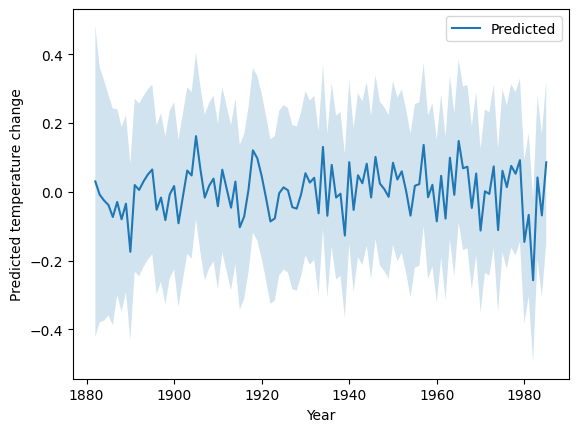

In [94]:
model = ARIMA(endog=firstorderdiff, order=(5, 1, 2)).fit()

predictions = model.get_prediction()
pred_mean = predictions.predicted_mean # the predicted values
ci = predictions.conf_int()

plt.plot(pred_mean.index[1:], pred_mean.values[1:], label='Predicted')
plt.fill_between(x=ci.index[1:], y1=ci['lower y'][1:], y2=ci['upper y'][1:], alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Predicted temperature change')
plt.legend()
plt.show()

In [105]:
mse_value = mse(firstorderdiff, pred_mean)
error_percent = mse_value / firstorderdiff.mean()
print("MSE: ", mse_value)
print("Error percentage: ", error_percent)
print("-"*40)
ljungbox(pred_mean)

MSE:  0.015587854591370487
Error percentage:  3.63716607131978
----------------------------------------
Ljungbox results:
      lb_stat     lb_pvalue
1    0.000034  9.953602e-01
2   11.617051  3.001853e-03
3   23.648679  2.957455e-05
4   23.803594  8.745112e-05
5   36.717687  6.822853e-07
6   44.079143  7.129709e-08
7   48.876683  2.398731e-08
8   51.243723  2.355110e-08
9   54.450767  1.549621e-08
10  57.943188  8.860309e-09


We can see from the plot above that the model seems to replicate the data relatively well. From the MSE we see a 3.6% average error for model prediction on the in-sample, which seems to be quite good. From the Ljung-box results, we see that the null hypothesis can not be rejected and thus the data set **is** random, as we wished.

### Step 6. Model forecasting. Use the validated model for future-value prediction. This is the out-of-sample prediction.

/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/labs/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


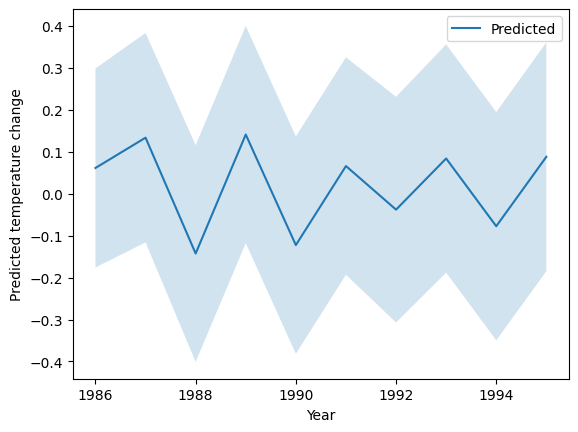

In [117]:
# predict the next 10 years
pred = model.get_forecast(steps=10)
pred_mean = pred.predicted_mean
ci = pred.conf_int()

# plot the prediction and adjust x-axis
idx_correction = [(1985 + (x-104)) for x in pred_mean.index]
plt.plot(idx_correction, pred_mean.values, label='Predicted')
plt.fill_between(x=idx_correction, y1=ci['lower y'], y2=ci['upper y'], alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Predicted temperature change')
plt.legend()
plt.show()

From the 10-step predicted values we can see that the model attempts to forecast the temperature change for the next 10 years. By visual inspection, the graph seems to follow the trend of the first order differenced data set.

### Questions

- Draw a line plot for the time series data. Do you observe any trend, season in the data?

There is no apparent seasonality, but there seems to be an upgoing trend for the temperature difference

- Draw histogram, density plot, heat map, and box plot for the time series data. Are there any outliers? Why?

There seems to be no outliers in the box plot. This is because we use real-world data without any errors in measurements. There seems to not be any super-natural weather conditions, therefore no outliers.

<Axes: title={'center': 'Density plot'}, ylabel='Density'>

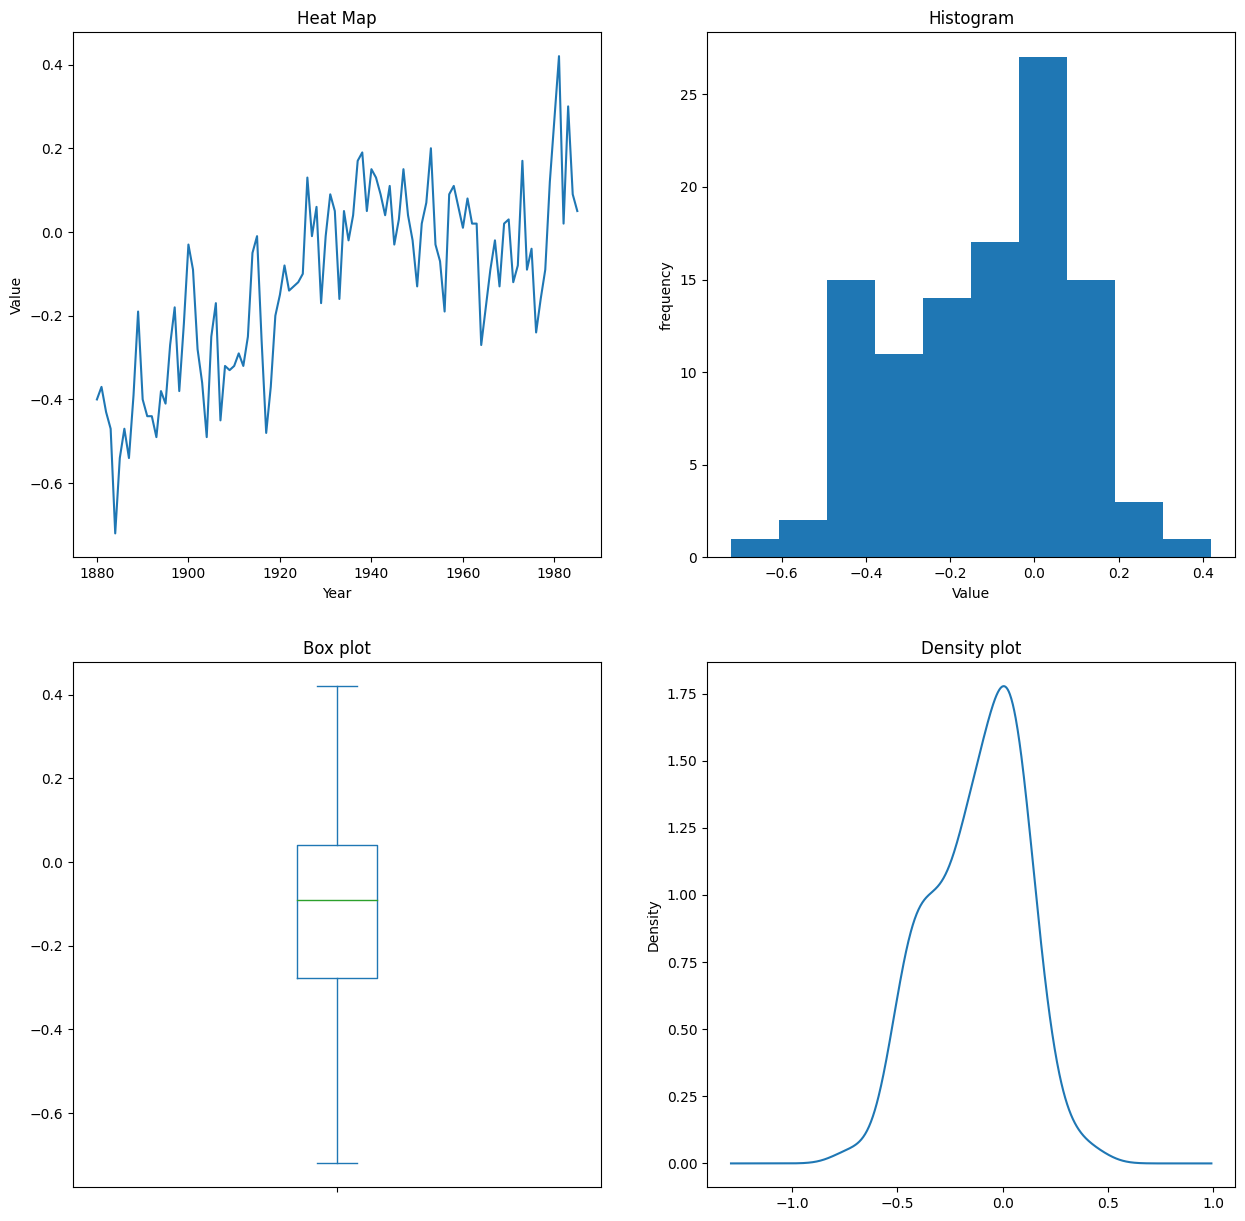

In [147]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

series.plot(ax=axes[0,0], x=series.index, title='Heat Map', xlabel='Year', ylabel='Value')
series.plot(ax=axes[0,1], kind='hist', title='Histogram', xlabel='Value', ylabel='frequency')
series.plot(ax=axes[1,0], kind='box', title='Box plot')
series.plot(ax=axes[1,1], kind='density', title='Density plot', xlabel='', ylabel='density')

- Draw lag-1 and lag-2 plots for the time series data. Do you observe any auto-correlation from the lag plots?

From visually inspecting the plots, we can conclude that there seems to be auto-correlation for both lags.

<Axes: xlabel='y(t)', ylabel='y(t + 2)'>

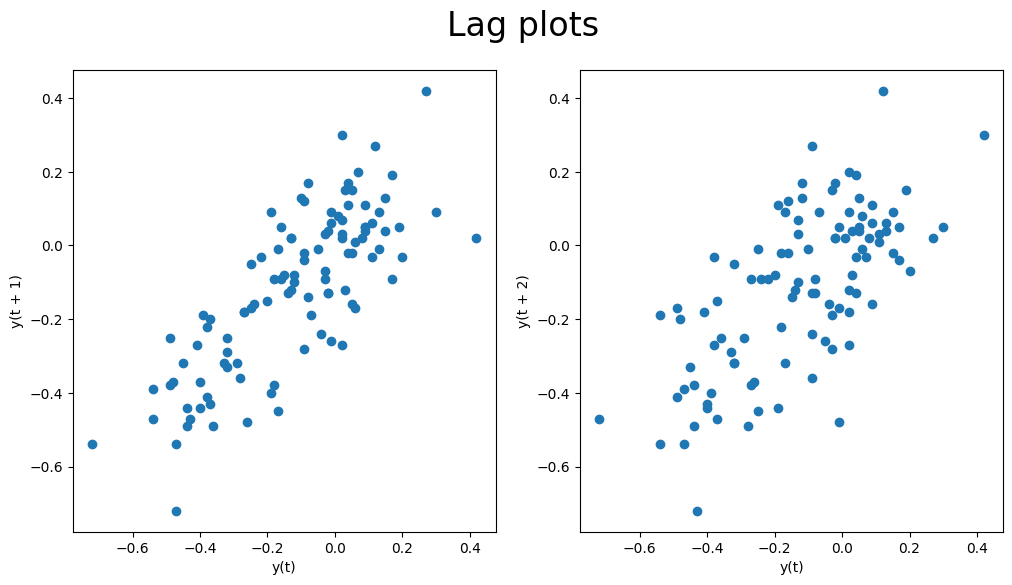

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
fig.subplots_adjust()
fig.suptitle("Lag plots", fontsize=24)
plotting.lag_plot(series, ax=axes[0], lag=1)
plotting.lag_plot(series, ax=axes[1], lag=2)

- Is the series random? How do you check it? Are the three methods (line plot, lag-1 plot, and Ljung-Box test) give the same results?

As can be observed in the above plots, it is obvious that the time series is not random, the line plot surely has an upwards trend and the lag-1 plot has a quite clear upwards trend. Furthermore, the Ljung-box test results indicate very small pvalues and implies that the null hypothesis (no auto-correlation) should be rejected, i.e. it can be concluded that there is auto-correlation in the time series.

- Is the series stationary? Try with visual inspection and ADF test. Do they give the same results?

It is apparent from visual inspection that the series is not stationary as it moves upwards. From the ADF results, the conclusion remains the same.

- If the series is not stationary, how do you make it stationary? If you use the differencing operation, how do you decide a proper order of differencing without underdifferencing/over-differencing?

The series is differenced with a differencing operation. Through trial and error a proper order of differencing can be found.

-  What (p, d, q) values do you use? How do you determine them?

The p-d-q values are found using the AIC criterion and grid searching (with the help of auto_arima() function). These are found to be 5-1-2. Parameter $d=1$ could be concluded by validating that the series was stationary after applying first order differencing.

- After model fitting, is the remainder series (in-sample prediction) considered to be white noise?

Yes. The results conclude that the remainder series is random and stationary, i.e. white noise.

- What is the MSE of the fitted model for the data?

The MSE is approximately 0.0156, or around 3.6%.

- For out-of-sample prediction, do the predicted values (10 steps) reflect the trend and fluctuation of the series?

The out-of-sample forecast seems to reflect the trend and fluctuation of the series.

# Task 6 - Series transformation

**There are a few transformations which can be used to stabilize trend, co-variance, and make the series stationary. In particular, differencing is the transformation recommended by the Box-Jenkins methodology.**

Answer the following general questions:
### What are the common transformation techniques applicable to turn a non-stationary series into a stationary series?

Differencing the series is a very basic transformation. It might also possible to apply seasonal decomposition to remove the seasonal and trend components to stabilize. Non-stable variance can be handled by transforming the series with a constant factor, such as taking the logarithm or square root of each value in the series to preserve ratios between data points but reduce variance.

### What is the Box-Cox transform? Give its definition and explain its generality.

The transformation is a family of transformation of time series that aims at trying to fit the input series to a normal distribution for further processing and analysis. Depending on the input data, the normal distribution will be different. Based on the given parameter lambda to the Box-Cox equation, the original data point $y_t$ is transformed to $z_t$

### Can a differencing operation remove a linear trend? Give an example by generating a synthetic series, and draw the series before differencing and after differencing.

Yes differencing can remove a linear trend. Since the linear coefficient is constant, the differencing operation will simply produce the coefficient k for all differenced data points $z_t$

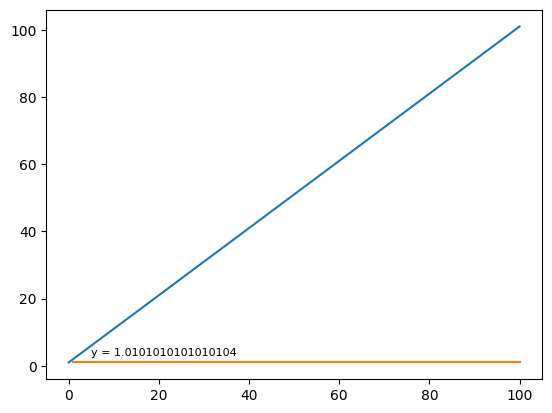

In [15]:
# create a straight line series for integer values between 0 and 100
x = np.linspace(0, 100, 100)
y = 1 * x + 1
# plot the straight line and plot the first order difference of the straight line
plt.plot(x, y, label='y = 1x + 1')
plt.plot(x[1:], np.diff(y), label='first order difference')
# display the y value of the first order difference right above the line
plt.text(5, 3, f'y = {np.diff(y)[0]}', fontsize=8);


### Can a differencing operation remove an exponential trend? If not, which additional transformation needs to be taken? Give an example by generating a synthetic series, and plots the series before transformation and after transformation, before differencing and after differencing.
By just applying the first order difference the exponential trend does not disappear, but if the series is differenced an arbitrary number of times the trend becomes linear and ultimately it can be differenced to remove the linear trend.

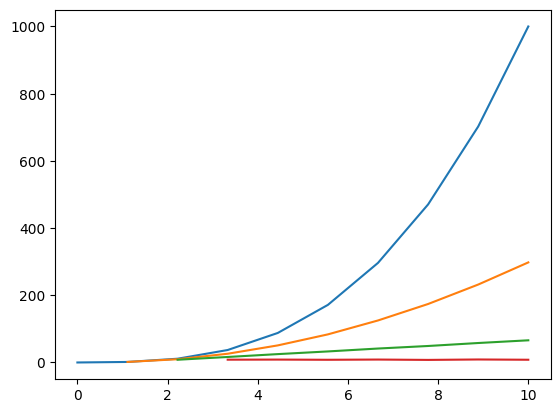

In [55]:
# create a series with an exponential square trend with gaussian noise
x = np.linspace(0, 10, 10)
y = x**3 + np.random.normal(0, 0.1, 10)

# plot the exponential trend series
plt.plot(x, y, label='y = x^3 + noise')
first_diff = np.diff(y)
# plot the first order difference of the exponential trend series
plt.plot(x[1:], first_diff, label='first order difference');
# plot the second order difference of the exponential trend series
second_diff = np.diff(y, 2)
plt.plot(x[2:], second_diff, label='first order difference');
# plot the thrird order difference of the exponential trend series
third_diff = np.diff(y, 3)
plt.plot(x[3:], third_diff, label='first order difference');

### Can a differencing operation remove a seasonal (periodic) trend? If yes, under what condition? Give an example by generating a synthetic series, draw its ACF, and draws the series before differencing and after differencing with different step length.
Yes, by using a differencing operation with order $\equal$ m, where m is the 

y[0]=0.0 y[1118]=-0.41539336008453176 y[1119]=-0.41062401814082145 y[120]=-0.4058434149788121 y[121]=-0.4010516817048495 


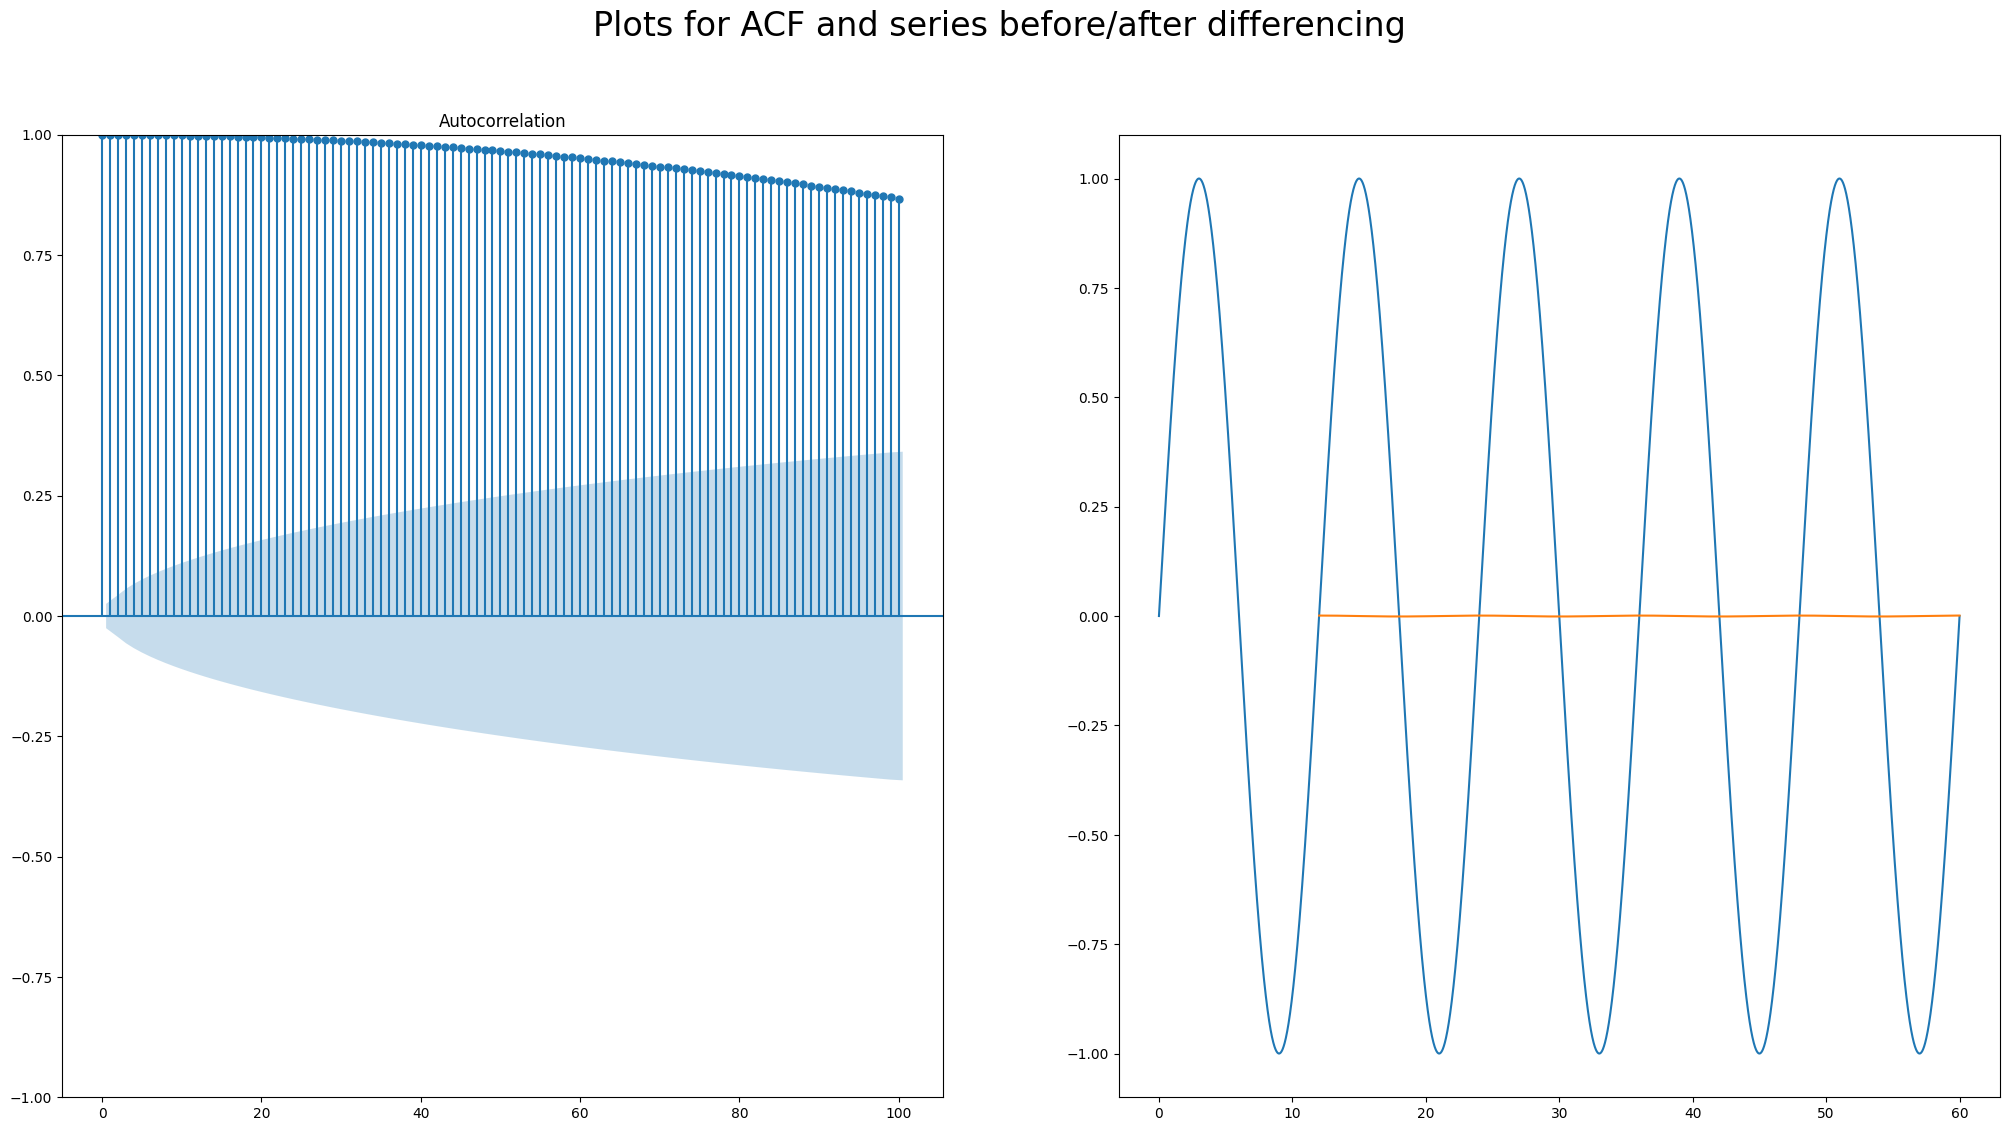

In [176]:
# create a series with a seasonal trend with gaussian noise with period 12
x = np.linspace(0, 60, 6000)
# create a sine wave with a period of 12
y = np.sin(2*np.pi*x/12)
seasonal_diff = [(y[i] - y[i-1200]) for i in range(1200, len(y))]
print(f"y[0]={y[0]} y[1118]={y[1118]} y[1119]={y[1119]} y[120]={y[1120]} y[121]={y[1121]} ")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 12.5))
fig.subplots_adjust()
fig.suptitle("Plots for ACF and series before/after differencing", fontsize=24)
plot_acf(Series(y), ax=axes[0], lags=100)

# plot the seasonal trend series and the seasonal difference
plt.plot(x, y, label='y = sin(x) + noise')
plt.plot(x[1200:], seasonal_diff, label='seasonal difference');